[LGBM에서 keyerror](https://github.com/microsoft/LightGBM/issues/3100)문제가 생길 수 있어 sklearn을 업그레이드 해줍니다.

In [17]:
!pip install scikit-learn --upgrade

In [458]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [459]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [460]:
data_dir = join(os.getcwd(), 'data')
train_data_path = join(data_dir, 'train.csv') ## train
sub_data_path = join(data_dir, 'test.csv') ## test

print(f"train data is in {train_data_path}")
print(f"sub(test) data is in {sub_data_path}")

train data is in /aiffel/aiffel/exploration-6-kaggle_kakr_housing/data/train.csv
sub(test) data is in /aiffel/aiffel/exploration-6-kaggle_kakr_housing/data/test.csv


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

### 데이터 불러오고 준비하기

1. 데이터를 불러옵니다.
2. train data에서 라벨에 해당하는 `price`를 제외해줍니다.
3. 전체 데이터에 대한 분석을 진행하기 위해 큰 데이터를 하나 만들어줍니다. 추후에 학습데이터를 불러오기 위해 train_len을 기억합니다.
    * 합친 데이터를 별도의 이름으로 저장하는 방법도 있습니다.

In [536]:
train_original = pd.read_csv(train_data_path) ## train
train_original.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

In [462]:
test_original = pd.read_csv(sub_data_path) ## test
test_original.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

In [463]:
data = pd.read_csv(train_data_path) ## train
sub = pd.read_csv(sub_data_path) ## test
print(f"train data dim: {data.shape}")
print(f"sub(test) data dim: {sub.shape}")

y = data['price']
data.drop("price", axis=1, inplace=True)
print(data.columns)
print("price" in data.columns)

train data dim: (15035, 21)
sub(test) data dim: (6468, 20)
Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
False


In [464]:
train_len = len(data)
data = pd.concat((data, sub), axis=0) # 이걸 다른 이름으로 설정하는 건 어떨까

print(len(data))
data.head()

21503


id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0   0  20141013T000000         3       1.00         1180      5650     1.0   
1   1  20150225T000000         2       1.00          770     10000     1.0   
2   2  20150218T000000         3       2.00         1680      8080     1.0   
3   3  20140627T000000         3       2.25         1715      6819     2.0   
4   4  20150115T000000         3       1.50         1060      9711     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        1180              0      1955   
1           0     0          3      6         770              0      1933   
2           0     0          3      8        1680              0      1987   
3           0     0          3      7        1715              0      1995   
4           0     0          3      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

## 2. 데이터 분석 및 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.

### (1) 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다. 결측치가 포함되있으면 해당 부분이 하얗게 나옵니다.

간단한 코드작성을 통해 실제 결과도 함께 알아보겠습니다.

id               0
date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

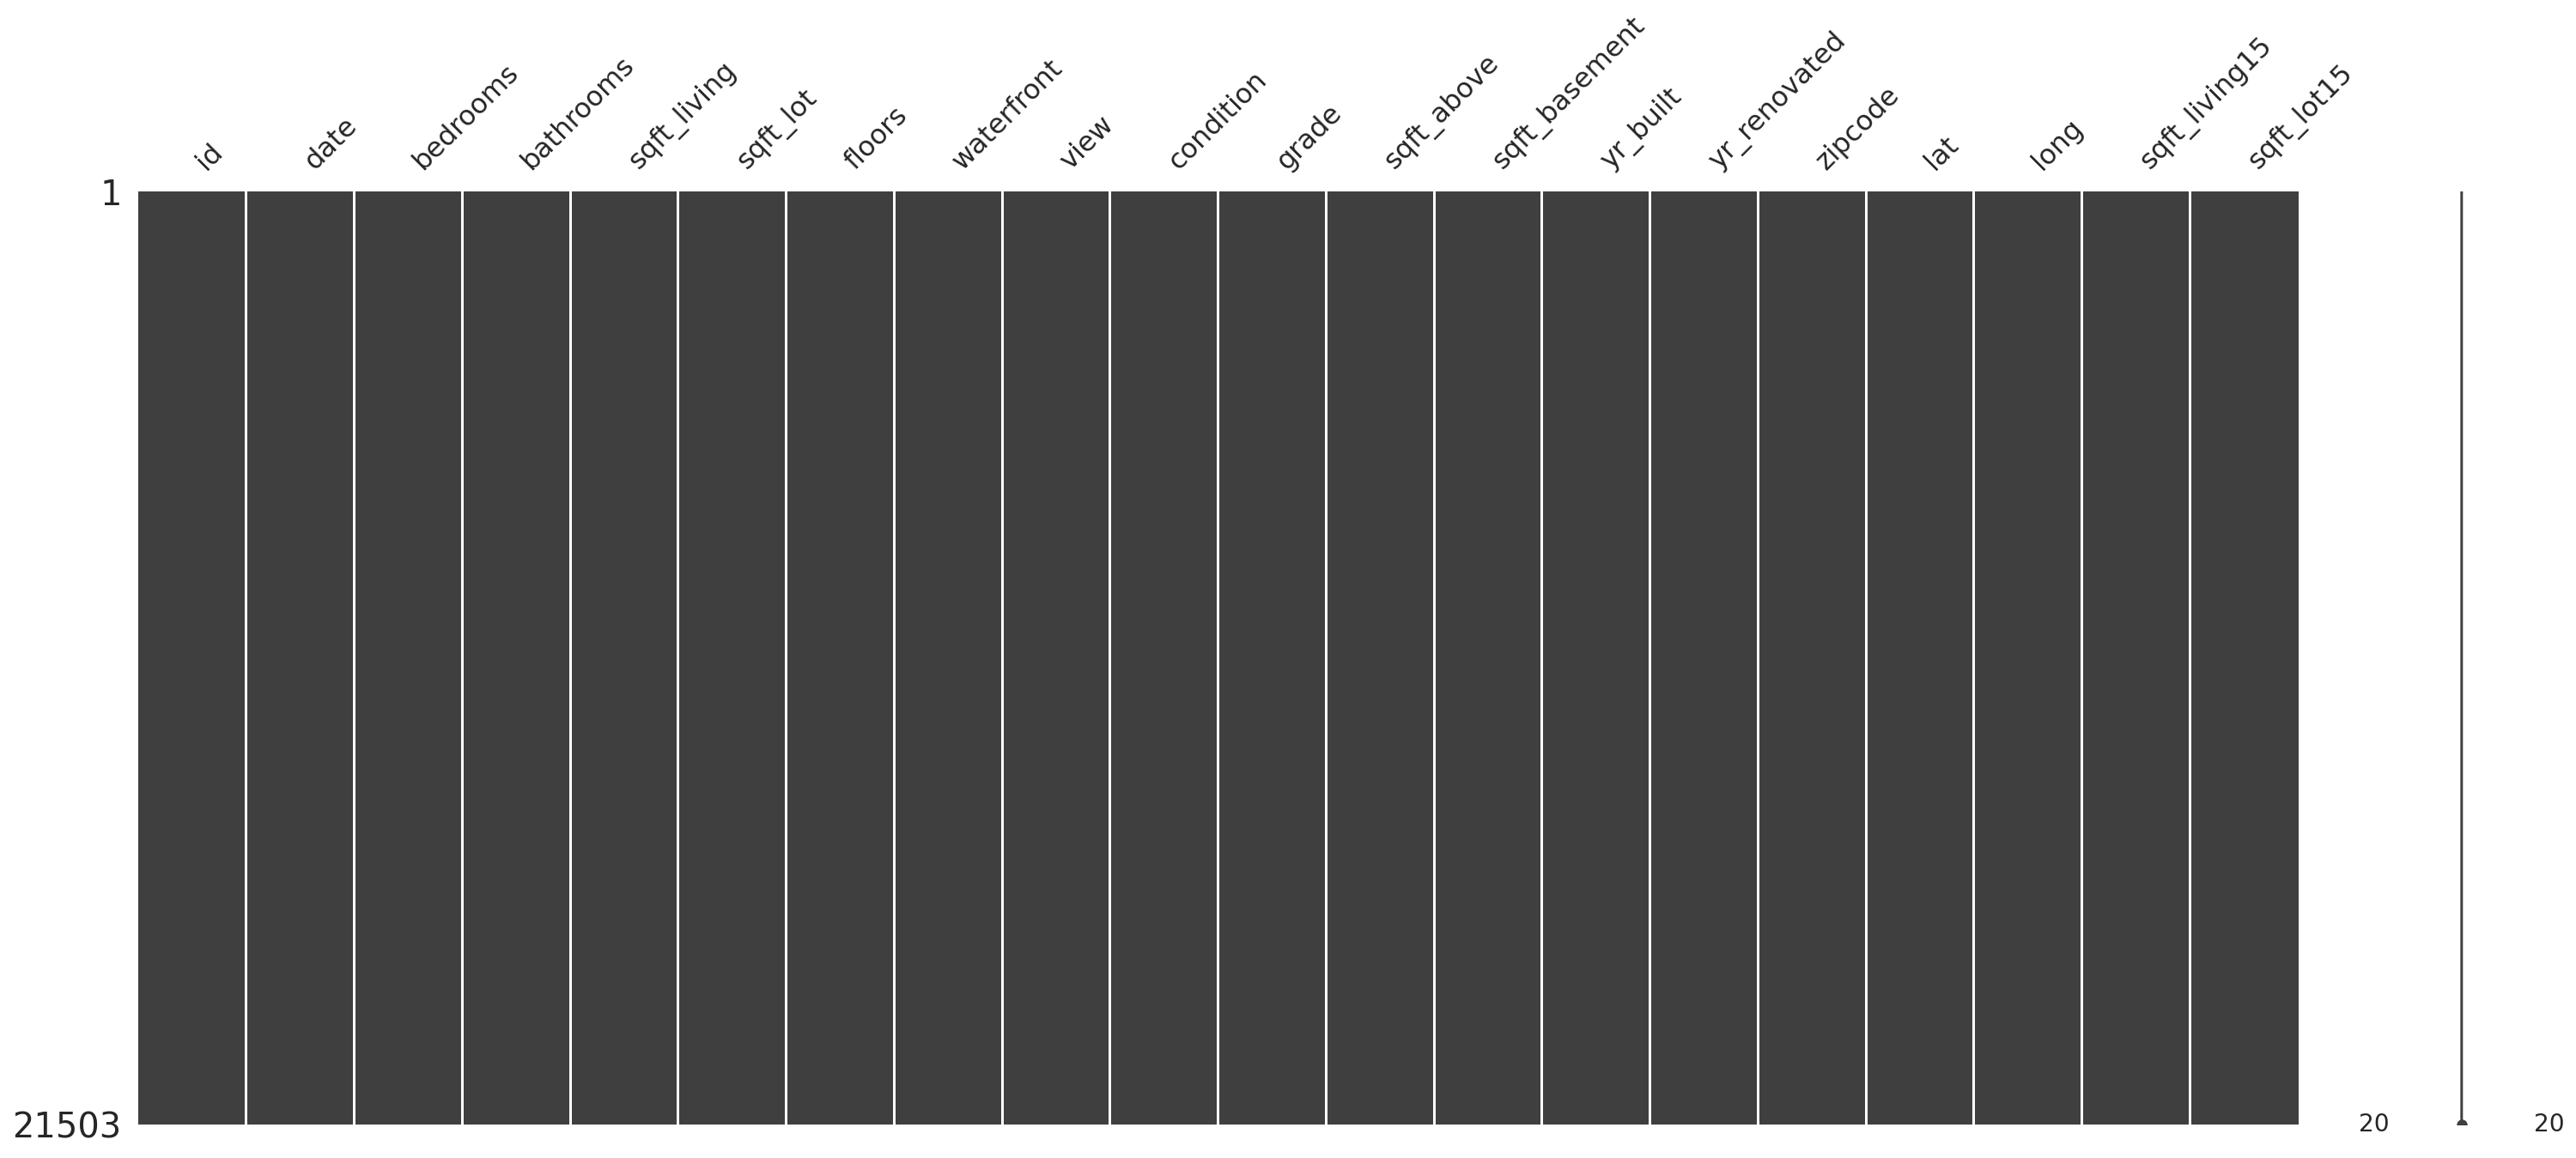

In [465]:
msno.matrix(data)
data.isnull().sum()

### (2) Checking each variables

각 변수에 담긴 의미와 구성이 어떻게 되있는 지 우선적으로 살펴보겠습니다. 살펴보면서는 전처리 중에서 이상치 제거에 초점을 두고 진행하겠습니다. 단 개별 변수에 대한 분석만을 진행하므로 가격과의 상관관계를 파악해서 하는 전처리는 다음 단계에서 진행하도록 하겠습니다.

#### (a) 'id' 컬럼삭제
`id` 컬럼을 우선 삭제해보겠습니다. `id` 컬럼은 집의 이름으로 모델이 예측할 때 유의미한 데이터로 사용할 수 없습니다. `id` 컬럼은 추후에 예측 결과를 제출할 때는 필요하므로 test에 해당하는 sub_data에 대한 `id`는 별도로 저장해줍니다.

In [466]:
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


#### (b) 'date' 컬럼

'date' 컬럼은 날짜를 의미하는 데이터로 일반적으로 `object` 자료형으로 저장되있습니다. 이는 string 데이터로 저장되어 있을 가능성이 높습니다. 이를 datetime으로 미리 처리해줄 수도 있지만, 모델의 학습에서 datetime 자료형을 제대로 처리하지 못할 때가 많습니다. (관련링크 추가하기)

아이러니하게도 그림을 그릴 때는 datetime 자료형일 때만 가능하거나 편한 경우가 많으므로 이에 유의하여 전처리를 해야합니다.

우선 여기서는 'date' 컬럼의 년/월/일 정보만 사용하기 위해 전처리를 하고 추후에 학습에 문제가 없도록 `int` 자료형으로 선언해주겠습니다. 

In [467]:
data['date'] = data['date'].apply(lambda x : str(x[:8])).astype("int")
data.head()


# parsedate 이용해서 수정해보자. date가 자기 마음대로 적혀있으면 적용이 안될수도 
# 미리 자르고 넣으면 괜찮을듯
# data['date'] = pd.to_datetime(data['date'], format="%Y%m") # -> 학습할 때는 category로


date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013         3       1.00         1180      5650     1.0           0   
1  20150225         2       1.00          770     10000     1.0           0   
2  20150218         3       2.00         1680      8080     1.0           0   
3  20140627         3       2.25         1715      6819     2.0           0   
4  20150115         3       1.50         1060      9711     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7        1180              0      1955             0   
1     0          3      6         770              0      1933             0   
2     0          3      8        1680              0      1987             0   
3     0          3      7        1715              0      1995             0   
4     0          3      7        1060              0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [468]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

#### (c) bedrooms
bedrooms는 침실의 갯수를 의미하는 변수입니다.

In [469]:
data['bedrooms'].describe()

count    21503.000000
mean         3.371762
std          0.930026
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

describe를 통해 살펴보면 최소값은 0 최대값은 33입니다. 좀 더 자세히 살펴보기 위해 갯수만 따로 모아서 확인 후 histplot을 그려보겠습니다.

In [470]:
bedroom_count = data['bedrooms'].value_counts().sort_index()
bedroom_count

0       13
1      195
2     2746
3     9764
4     6860
5     1592
6      271
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

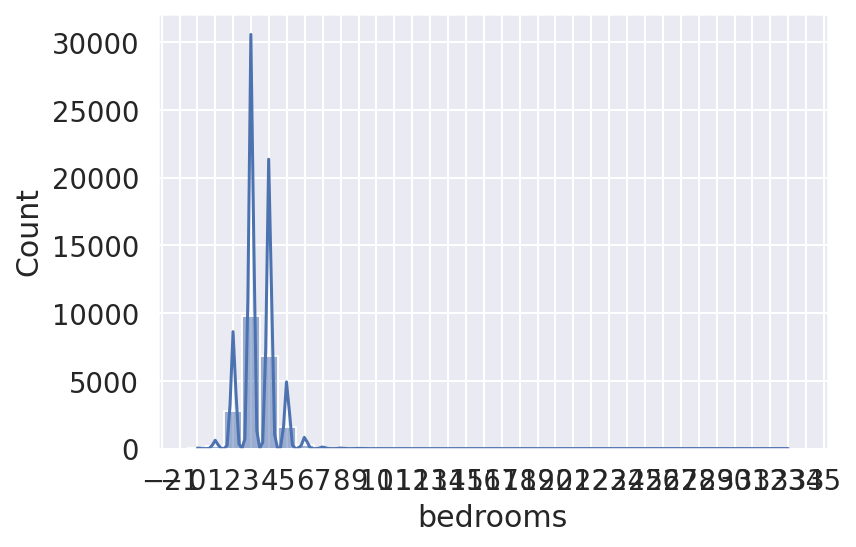

In [471]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
sns.histplot(data=data, x='bedrooms', discrete=True, kde=True, ax=ax)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

전체적인 분포가 skew된 모양이기도 하고 outlier가 있으므로 outlier 관련해서 처리를 해보도록 하겠습니다. 임의로 침실이 9개 이상인 데이터를 가져와 `sqft_living`과 비교하며 판단해보겠습니다.

참고로 100sqft가 2.8평 정도 되는 크기입니다.

In [472]:
data.loc[data['bedrooms'] >= 9]

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
2912   20140507         9       4.50         3830      6988     2.5   
3010   20150106         9       3.00         3680      4400     2.0   
4291   20140808         9       4.50         3650      5000     2.0   
5990   20140811         9       7.50         4050      6504     2.0   
9280   20140814        10       5.25         4590     10920     1.0   
10575  20141029        10       2.00         3610     11914     2.0   
12824  20150313         9       3.00         2820      4480     2.0   
2584   20140821        11       3.00         3000      4960     2.0   
4710   20140625        33       1.75         1620      6000     1.0   
5020   20150317         9       4.00         4620      5508     2.5   
5775   20141229        10       3.00         2920      3745     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
2912            0     0          3      7        2450           1380   
3010            0     0          3      7        2830            850   
4291            0     0          3      8        2530           1120   
5990            0     0          3      7        4050              0   
9280            0     2          3      9        2500           2090   
10575           0     0          4      7        3010            600   
12824           0     0          3      7        1880            940   
2584            0     0          3      7        2400            600   
4710            0     0          5      7        1040            580   
5020            0     0          3     11        3870            750   
5775            0     0          4      7        1860           1060   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
2912       1938             0    98103  47.6927 -122.338           1460   
3010       1908             0    98102  47.6374 -122.324           1960   
4291       1915          2010    98105  47.6604 -122.289           2510   
5990       1996             0    98144  47.5923 -122.301           1448   
9280       2008             0    98004  47.5861 -122.113           2730   
10575      1958             0    98006  47.5705 -122.175           2040   
12824      1918             0    98105  47.6654 -122.307           2460   
2584       1918          1999    98106  47.5560 -122.363           1420   
4710       1947             0    98103  47.6878 -122.331           1330   
5020       1915             0    98105  47.6684 -122.309           2710   
5775       1913             0    98105  47.6635 -122.320           1810   

       sqft_lot15  
2912         6291  
3010         2450  
4291         5000  
5990         3866  
9280        10400  
10575       11914  
12824        4400  
2584         4960  
4710         4700  
5020         4320  
5775         3745

4710번 집을 살펴보면 침실의 갯수는 33개인데 `sqft_living`은 1620으로 45평 정도에 불과합니다. 게다가 층수도 1층인 것을 감안하면 이 값은 다른 값에 비해 유달리 이상한 값으로 보입니다.  이외에 2820sqft에 침실이 9개 있는 경우는 약 80평에 침실이 9개인 집은 층수도 2층이고 현실성이 매우 떨어지는 값은 아니라고 생각해 따로 고려하지 않았습니다.

#### (d) bathrooms

In [474]:
data['bathrooms'].describe()

count    21503.000000
mean         2.116042
std          0.770018
min          0.000000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

욕실의 갯수는 25%, 50%, 75% 값을 확인해보니 소수값 형태로 나옵니다. 이는 [discussion](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/discussion/83533)탭을 통해 확인해보면, full bat, $\frac{3}{4}$ bath, half bath 등으로 표기하는 미국의 구분법에 의한 것으로 이해할 수 있습니다. 특이한 값이 없는 지 위와 같이 한번 확인해보겠습니다.

In [475]:
bathroom_count = data['bathrooms'].value_counts().sort_index()
bathroom_count

0.00      10
0.50       4
0.75      71
1.00    3820
1.25       9
1.50    1438
1.75    3029
2.00    1921
2.25    2034
2.50    5364
2.75    1183
3.00     750
3.25     586
3.50     729
3.75     155
4.00     135
4.25      79
4.50      99
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: bathrooms, dtype: int64

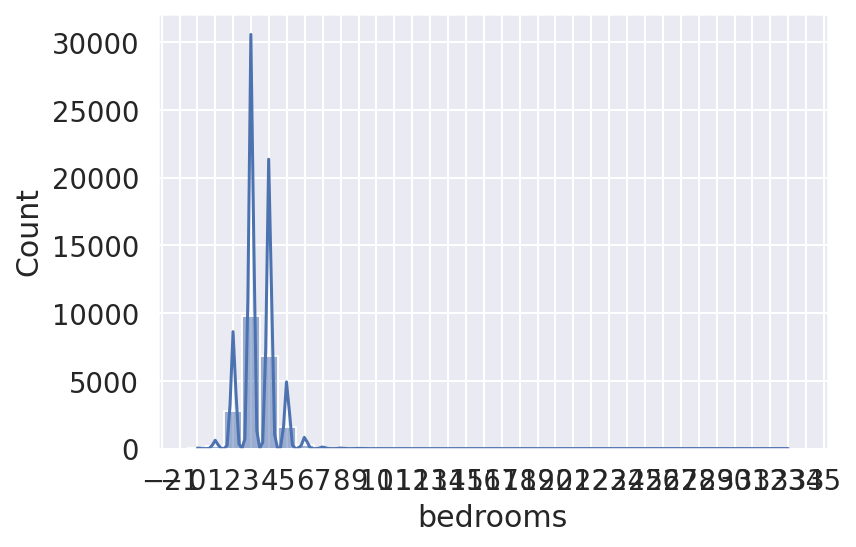

In [476]:
fig, ax = plt.subplots()
sns.histplot(data=data, x='bedrooms', discrete=True, kde=True, ax=ax)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

위와 같이 `sqft_living` 값과 함께 살펴봤을 때 bathrooms의 경우 이상치라고 할 값은 없어 보입니다.

In [477]:
data.loc[data['bathrooms'] >= 6]

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
947    20150413         6       6.00         7390     24829     2.0   
2859   20141007         7       6.75         7480     41664     2.0   
5108   20141013         6       8.00        12050     27600     2.5   
5990   20140811         9       7.50         4050      6504     2.0   
6469   20140919         6       7.75         9890     31374     2.0   
8912   20140505         7       8.00        13540    307752     3.0   
10152  20140611         5       6.25         8670     64033     2.0   
13311  20141011         5       6.00         5490     19897     2.0   
1147   20141007         8       6.00         4340      9415     2.0   
2365   20140617         5       6.75         9640     13068     1.0   
3677   20150506         5       6.00         7440     21540     2.0   
5475   20140702         5       6.25         8020     21738     2.0   
6167   20150328         6       6.50         6260     10955     2.0   
6321   20150219         5       6.00         7120     40806     2.0   
6401   20140822         5       6.00         6880    279968     2.0   
6440   20140509         5       6.50         7270    130017     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
947             1     4          4     12        5000           2390   
2859            0     2          3     11        5080           2400   
5108            0     3          4     13        8570           3480   
5990            0     0          3      7        4050              0   
6469            0     4          3     13        8860           1030   
8912            0     4          3     12        9410           4130   
10152           0     4          3     13        6120           2550   
13311           0     0          3     12        5490              0   
1147            0     0          3      8        4340              0   
2365            1     4          3     12        4820           4820   
3677            0     0          3     12        5550           1890   
5475            0     0          3     11        8020              0   
6167            0     0          3     11        4840           1420   
6321            0     4          3     12        5480           1640   
6401            0     3          3     12        4070           2810   
6440            0     0          3     12        6420            850   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
947        1991             0    98040  47.5631 -122.210           4320   
2859       1953             0    98166  47.4643 -122.368           2810   
5108       1910          1987    98102  47.6298 -122.323           3940   
5990       1996             0    98144  47.5923 -122.301           1448   
6469       2001             0    98039  47.6305 -122.240           4540   
8912       1999             0    98053  47.6675 -121.986           4850   
10152      1965          2003    98177  47.7295 -122.372           4140   
13311      2005             0    98039  47.6165 -122.236           2910   
1147       1967             0    98004  47.6316 -122.202           2050   
2365       1983          2009    98040  47.5570 -122.210           3270   
3677       2003             0    98006  47.5692 -122.189           4740   
5475       2001             0    98006  47.5675 -122.189           4160   
6167       2007             0    98075  47.5947 -122.039           2710   
6321       2007             0    98006  47.5451 -122.114           3440   
6401       2007             0    98045  47.4624 -121.779           4690   
6440       2010             0    98027  47.5371 -121.982           1800   

       sqft_lot15  
947         24619  
2859        33190  
5108         8800  
5990         3866  
6469        42730  
8912       217800  
10152       81021  
13311       17600  
1147         9100  
2365        10454  
3677        19329  
5475        18969  
6167        12550  
6321        36859  
64

#### (e) sqft_living, sqft_lot
sqft_living은 주거공간의 면적, sqft_lot은 부지의 면적이라고 할 수 있습니다. 

둘의 관계에 대해서는 쉽게 결론 내릴 수 없습니다. 부지 전부를 주거공간으로 사용할 경우에는 층이 많을 경우 부지의 면적보다 주거공간의 면적이 더 크게 되고, 부지 전부를 주거공간으로 사용하지 않을 경우에는 부지의 면적이 더 크게 됩니다. 

위 사실 또한 염두에 두고 두 변수에 대해서 분석해보겠습니다. 

In [478]:
data['sqft_living'].describe()

count    21503.000000
mean      2081.441334
std        918.669624
min        290.000000
25%       1430.000000
50%       1914.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [479]:
data['sqft_lot'].describe()

count    2.150300e+04
mean     1.511715e+04
std      4.147591e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.616000e+03
75%      1.068600e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

부지를 의미하는 sqft_lot의 경우 그 분포가 더욱 뾰족하기 때문에 logscale을 이용해 그려보도록 하겠습니다. 추후에 feature engineering에서 log 변환을 해줄 예정이기 때문에 별도의 변환은 여기서는 진행하지 않겠습니다.

<AxesSubplot:xlabel='sqft_lot', ylabel='Count'>

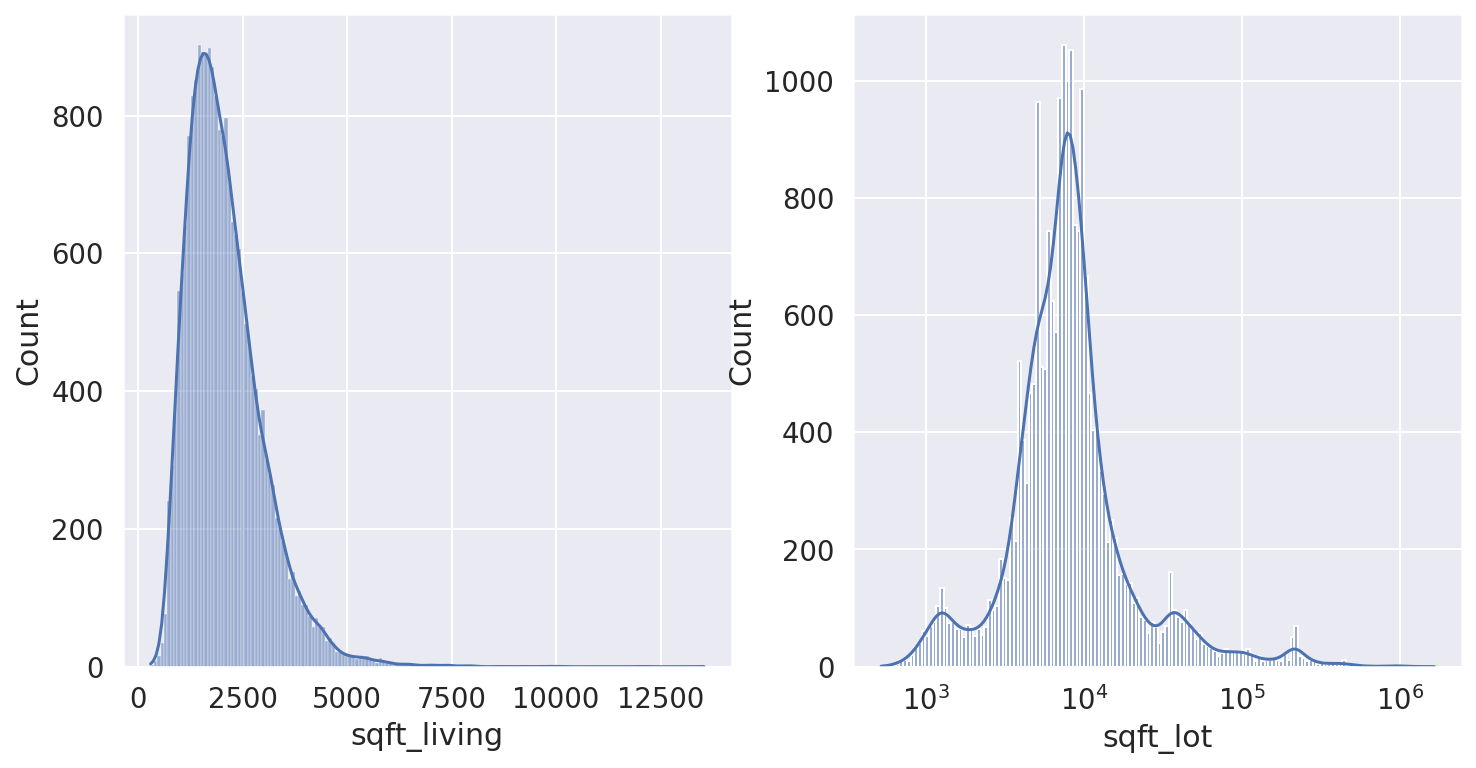

In [480]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

axs = axes.ravel()

sns.histplot(data=data, x='sqft_living', kde=True, ax=axs[0])
sns.histplot(data=data, x='sqft_lot', kde=True, log_scale=True, ax=axs[1])

대부분의 데이터가 0~6000 사이에 모여있고 이것보다 큰 값들도 꽤 많이 존재하고 있습니다. 하지만 아주 작은값과 큰 값에 대한 데이터도 존재하고 있고 이런 이상값들에 대해 확인해보겠습니다.

[]

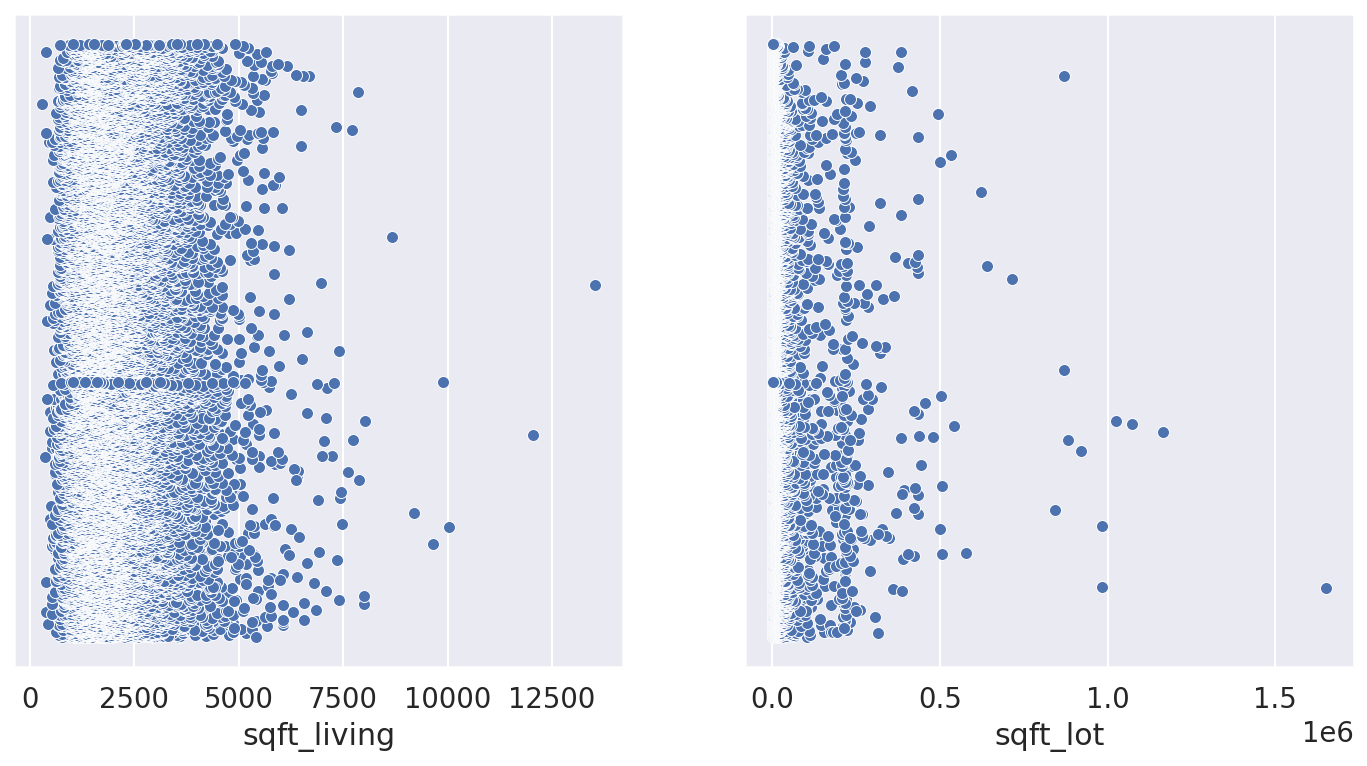

In [481]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs = axes.ravel()

sqft_living_data = data['sqft_living']
sns.scatterplot(x=sqft_living_data.values, y=sqft_living_data.index, ax=axs[0])
axs[0].set_xlabel("sqft_living")
axs[0].set_ylabel("")
axs[0].set_yticks([])

sqft_lot_data = data['sqft_lot']
sns.scatterplot(x=sqft_lot_data.values, y=sqft_lot_data.index, ax=axs[1])
axs[1].set_xlabel("sqft_lot")
axs[1].set_ylabel("")
axs[1].set_yticks([])

둘의 관계는 여전히 산점도를 통해서 살펴보았을 때는 유의미한 관계가 있다고 보기 힘듭니다.

<AxesSubplot:xlabel='sqft_living15', ylabel='sqft_lot15'>

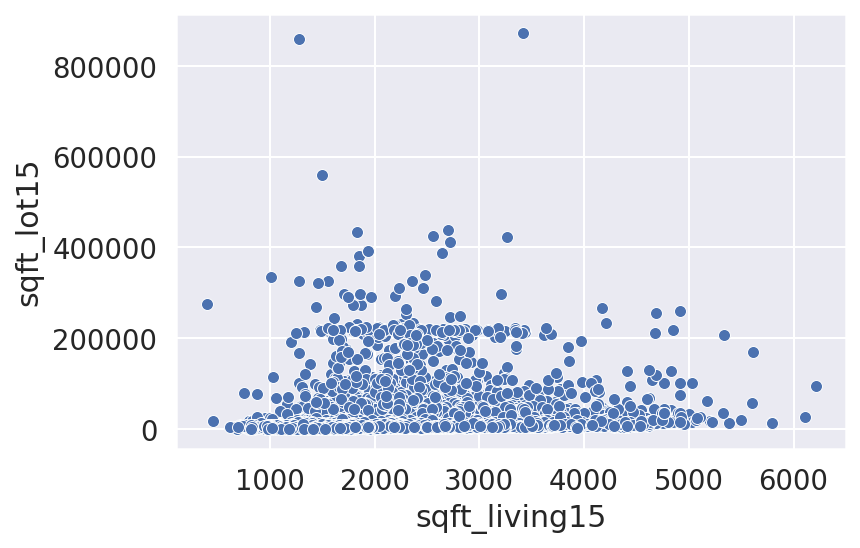

In [482]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x='sqft_living15', y='sqft_lot15')

각각의 큰 값들을 체크하는 방법만을 통해서는 이상치라고 판단할만한 수치가 눈에 띄지는 않습니다.

뒤늦게 발견한 사항으로 지금까지 이상치로 체크해본 값들은 대부분 평균보다 훨씬 큰 값이였습니다. 지금까지 다른 모든 변수들을 다시 한번 살펴보면 대부분 위도와 경도가 비슷한 곳에 위치해있습니다. 이를 통해 어느 정도 큰 집, 욕실, 침실이 많은 집은 대부분 비슷한 위치에 있는 것을 알 수 있고 당연하게도 집의 크기(sqft_living)과 욕실, 침실의 수가 비슷한 관계가 있다는 것도 짐작할 수 있습니다.

#### (f) floors, waterfront, view, condition, grade
위의 변수들은 의미상 이산적인 데이터임을 유추할 수 있습니다. 각각 floors는 층의 갯수, waterfront는 집 앞의 강의 유무, view는 _Has been viewed_ 라고 되어있는 것으로 보아 누군가 본 횟수로 생각할 수도 있을 것 같고, condition, grade의 경우는 어떠한 점수가 매겨진 데이터라고 생각할 수 있을 것 같습니다. (일반적으로 컨디션을 생각하면 S, A, B 등을 생각할 수 있듯이!)

이러한 변수들이 어떻게 구성되어있는 지 개별적으로 살펴보기 전에 유니크한 값들의 갯수를 보고 어떤 변수인 지 파악해보겠습니다.

In [483]:
columns = ['floors', 'waterfront', 'view', 'condition', 'grade']
unique_nums = []
for col in columns:
    unique_nums.append(len(data[col].unique()))

unique_df = pd.DataFrame()
unique_df['Columns'] = columns
unique_df['Unique_value'] = unique_nums
unique_df

Columns  Unique_value
0      floors             6
1  waterfront             2
2        view             5
3   condition             5
4       grade            12

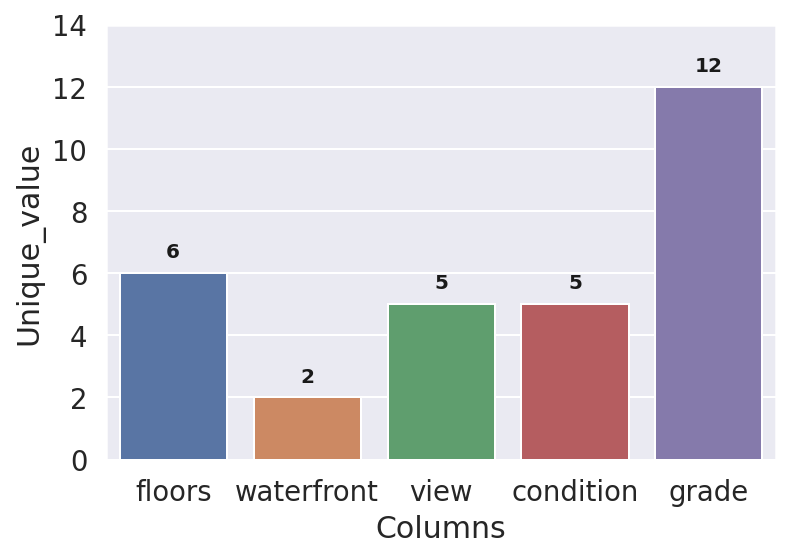

In [484]:
fig, ax = plt.subplots()
sns.barplot(data=unique_df, x='Columns', y='Unique_value')
ax.set_ylim(0, 14)
for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(int(height), (left+width/2, height+0.5), ha='center', color='k', fontweight='bold')

In [485]:
columns = ['floors', 'waterfront', 'view', 'condition', 'grade']
indexes = []
for col in columns:
    indexes.append(list(data[col].value_counts().sort_index().index))
    
indexes_df = pd.DataFrame()
indexes_df['Columns'] = columns
indexes_df['Indexes'] = indexes
indexes_df

Columns                                   Indexes
0      floors            [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
1  waterfront                                    [0, 1]
2        view                           [0, 1, 2, 3, 4]
3   condition                           [1, 2, 3, 4, 5]
4       grade  [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

이를 통해 살펴보면,
* floors: 층 갯수, 소숫점은 다락방을 의미한다.
* waterfront: 리버뷰 유무
* view, condition, grade: 수치를 순위화한 데이터
    * grade의 경우 2가 없다.

로 생각해볼 수 있습니다.

#### (g) sqft_above, sqft_basement

sqft_above는 지하실을 제외한 평방 피트, sqft_basement는 지하실의 평방 피트를 의미합니다. 따라서 지하실이 없는 경우를 고려해보면 sqft_living과 비슷하거나 같은 분포를 보일 것이고 실제 분포 또한 비슷하게 나오는 것을 알 수 있습니다. 의미적으로 sqft_living = sqft_above + sqft_basement 일 것으로 예상되는데 이 또한 확인해보겠습니다.

In [486]:
flag = np.sum(data['sqft_living'] != data['sqft_above'] + data['sqft_basement'])
if not flag:
    print("sqft_living = sqft_above + sqft_basement")

sqft_living = sqft_above + sqft_basement


예상한 의미가 맞음을 알 수 있습니다. 이를 통해 개별 변수만으로 분석할 수 있는 것은 딱히 없어보이므로 간단한 시각화와 describe를 통한 체크만 진행하도록 하겠습니다.

In [487]:
data['sqft_above'].describe()

count    21503.000000
mean      1789.765986
std        828.481664
min        290.000000
25%       1200.000000
50%       1560.000000
75%       2210.000000
max       9410.000000
Name: sqft_above, dtype: float64

In [488]:
data['sqft_basement'].describe()

count    21503.000000
mean       291.675348
std        442.645882
min          0.000000
25%          0.000000
50%          0.000000
75%        560.000000
max       4820.000000
Name: sqft_basement, dtype: float64

<AxesSubplot:xlabel='sqft_basement', ylabel='Count'>

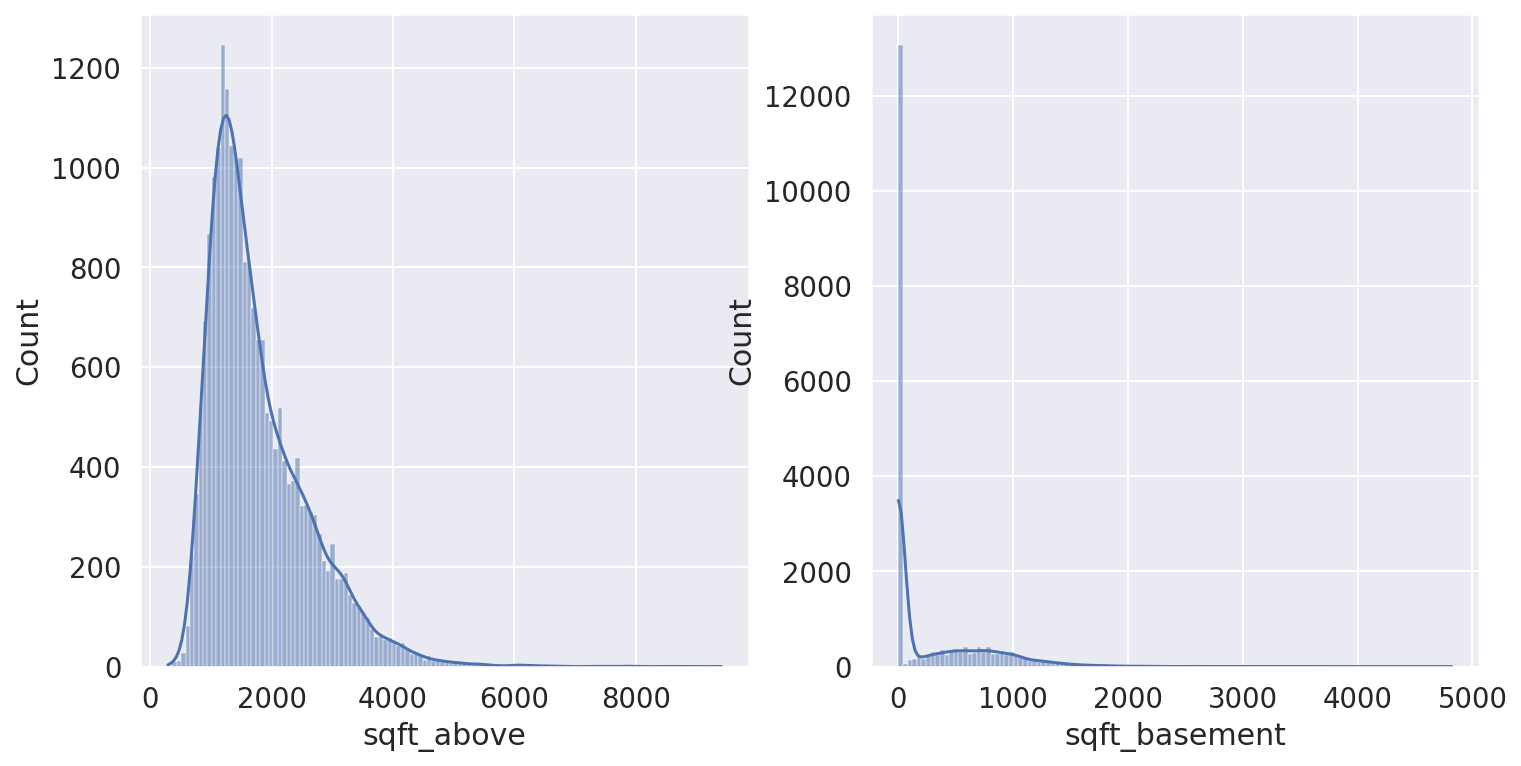

In [489]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs = axes.ravel()
sns.histplot(data=data, x='sqft_above', kde=True, ax=axs[0])
sns.histplot(data=data, x='sqft_basement', kde=True, ax=axs[1])

[]

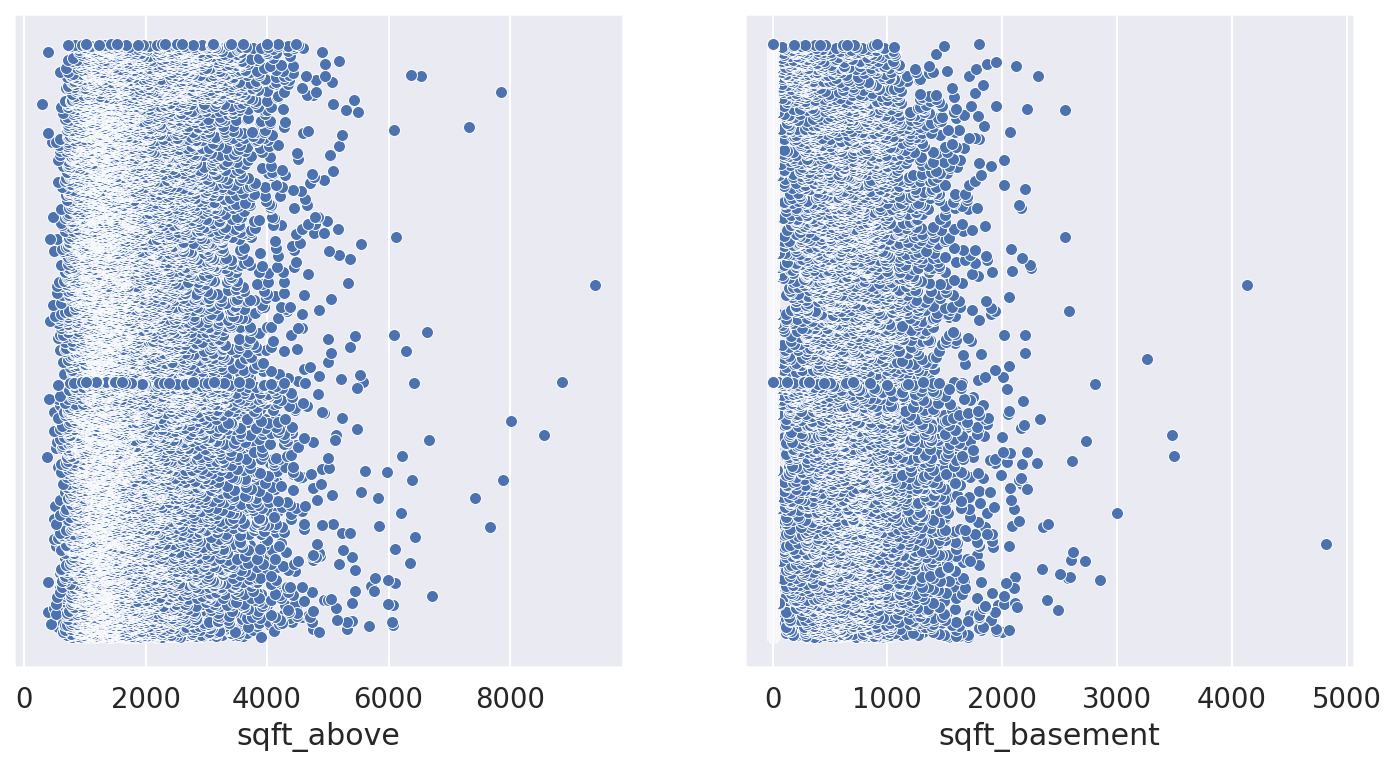

In [490]:
sqft_above_data = data['sqft_above']
sqft_basement_data = data['sqft_basement']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs = axes.ravel()

sns.scatterplot(x=sqft_above_data.values, y=sqft_above_data.index, ax=axs[0])
axs[0].set_xlabel("sqft_above")
axs[0].set_ylabel("")
axs[0].set_yticks([])

sns.scatterplot(x=sqft_basement_data.values, y=sqft_basement_data.index, ax=axs[1])
axs[1].set_xlabel("sqft_basement")
axs[1].set_ylabel("")
axs[1].set_yticks([])

#### (h) yr_built, yr_renovated
yr_built와 yr_renovated는 각각 지어진 년도와 집을 재건축한 년도를 의미합니다. 하지만 재건축을 하지 않은 집도 있을 것으로 예상되므로 이에 유의해 살펴보겠습니다. (yr_built가 없는 집을 없을 것으로 생각됩니다.) 이 두 변수 또한 년도를 의미하므로 이산형 변수임을 염두에 두겠습니다.

In [491]:
display(data['yr_built'].describe())
display(data['yr_renovated'].describe())

count    21503.000000
mean      1971.055016
std         29.372398
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

count    21503.000000
mean        84.741943
std        402.452836
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

생각한대로 yr_renovated의 경우 최소값이 0인 것으로 보아 재건축을 하지 않은 경우 0으로 값이 들어가있습니다.

In [492]:
yr_built_count = data['yr_built'].value_counts().sort_index()
yr_built_count

1900     86
1901     29
1902     27
1903     45
1904     44
       ... 
2011    130
2012    169
2013    200
2014    558
2015     38
Name: yr_built, Length: 116, dtype: int64

In [493]:
yr_renovated_count = data['yr_renovated'].value_counts().sort_index()
yr_renovated_count

0       20590
1934        1
1940        2
1944        1
1945        3
        ...  
2011       13
2012       11
2013       37
2014       91
2015       16
Name: yr_renovated, Length: 70, dtype: int64

yr_renovated의 경우 대부분의 집이 재건축이 되지 않아 0값이 많으므로 이 값을 제외하고 시각화를 진행해보겠습니다.

<AxesSubplot:xlabel='yr_renovated', ylabel='Count'>

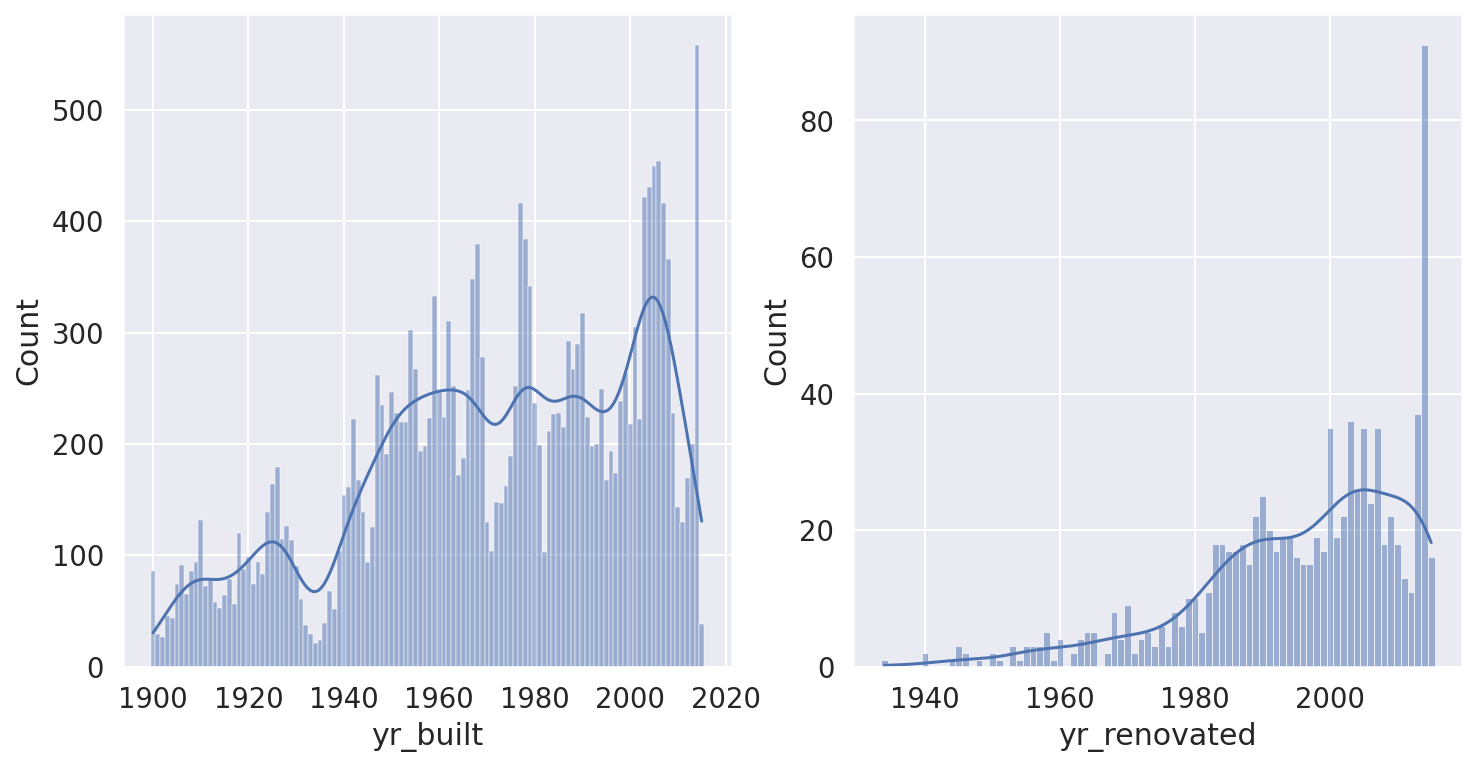

In [494]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs = axes.ravel()
sns.histplot(data=data, x='yr_built', discrete=True, kde=True, ax=axs[0])

renovated_data = data.loc[data['yr_renovated'] > 0]
sns.histplot(data=renovated_data, x='yr_renovated', discrete=True, kde=True, ax=axs[1])

두 변수 모두 시간이 지남에 따라 증가하다가 마지막에 떨어지는 모양이지만 yr_built에 비해 yr_renovate가 비교적 굴곡이 없이 증가하는 모습임을 알 수 있습니다. 그리고 두 분포 모두 유달리 2014년에 peak를 보이고 있음을 알 수 있습니다.

#### (i) long, lat, zipcode
long, lat은 기본적으로 경도, 위도를 의미하고 zipcode는 우편번호입니다. 미국의 zipcode에 대해서 대략적으로 알아보면 5개의 숫자로 구성되어있으며 (National Area, {Sectional Center of Large City Post Office}, {Associate Post Office or Delivery Area})로 이루어져있습니다. 괄호안의 {}는 각각 2개의 숫자로 이루어져있습니다. 더 상세한 주소는 이 zipcode에 추가로 4개의 숫자로 구성되어있습니다. 따라서 이 경우 겹치는 zipcode가 존재할 것으로 생각이 됩니다. 또한 zipcode의 경우 숫자적인 의미(numerical)하지 않으므로 string형으로 우선 바꿔주겠습니다.

결국에는 이 세 변수 모두 위치에 대한 데이터이므로 이를 고려해 시각화하고 분석해보겠습니다.

우선 유니크한 zipcode의 갯수를 세보겠습니다.

In [495]:
data['zipcode'] = data.zipcode.astype("string")

In [496]:
len(data['zipcode'].unique())

70

70개로 전체 데이터에 비해 적은 숫자임을 알 수 있고 비슷한 지역에 위치해있다는 것을 알 수 있습니다.

<AxesSubplot:xlabel='lat', ylabel='long'>

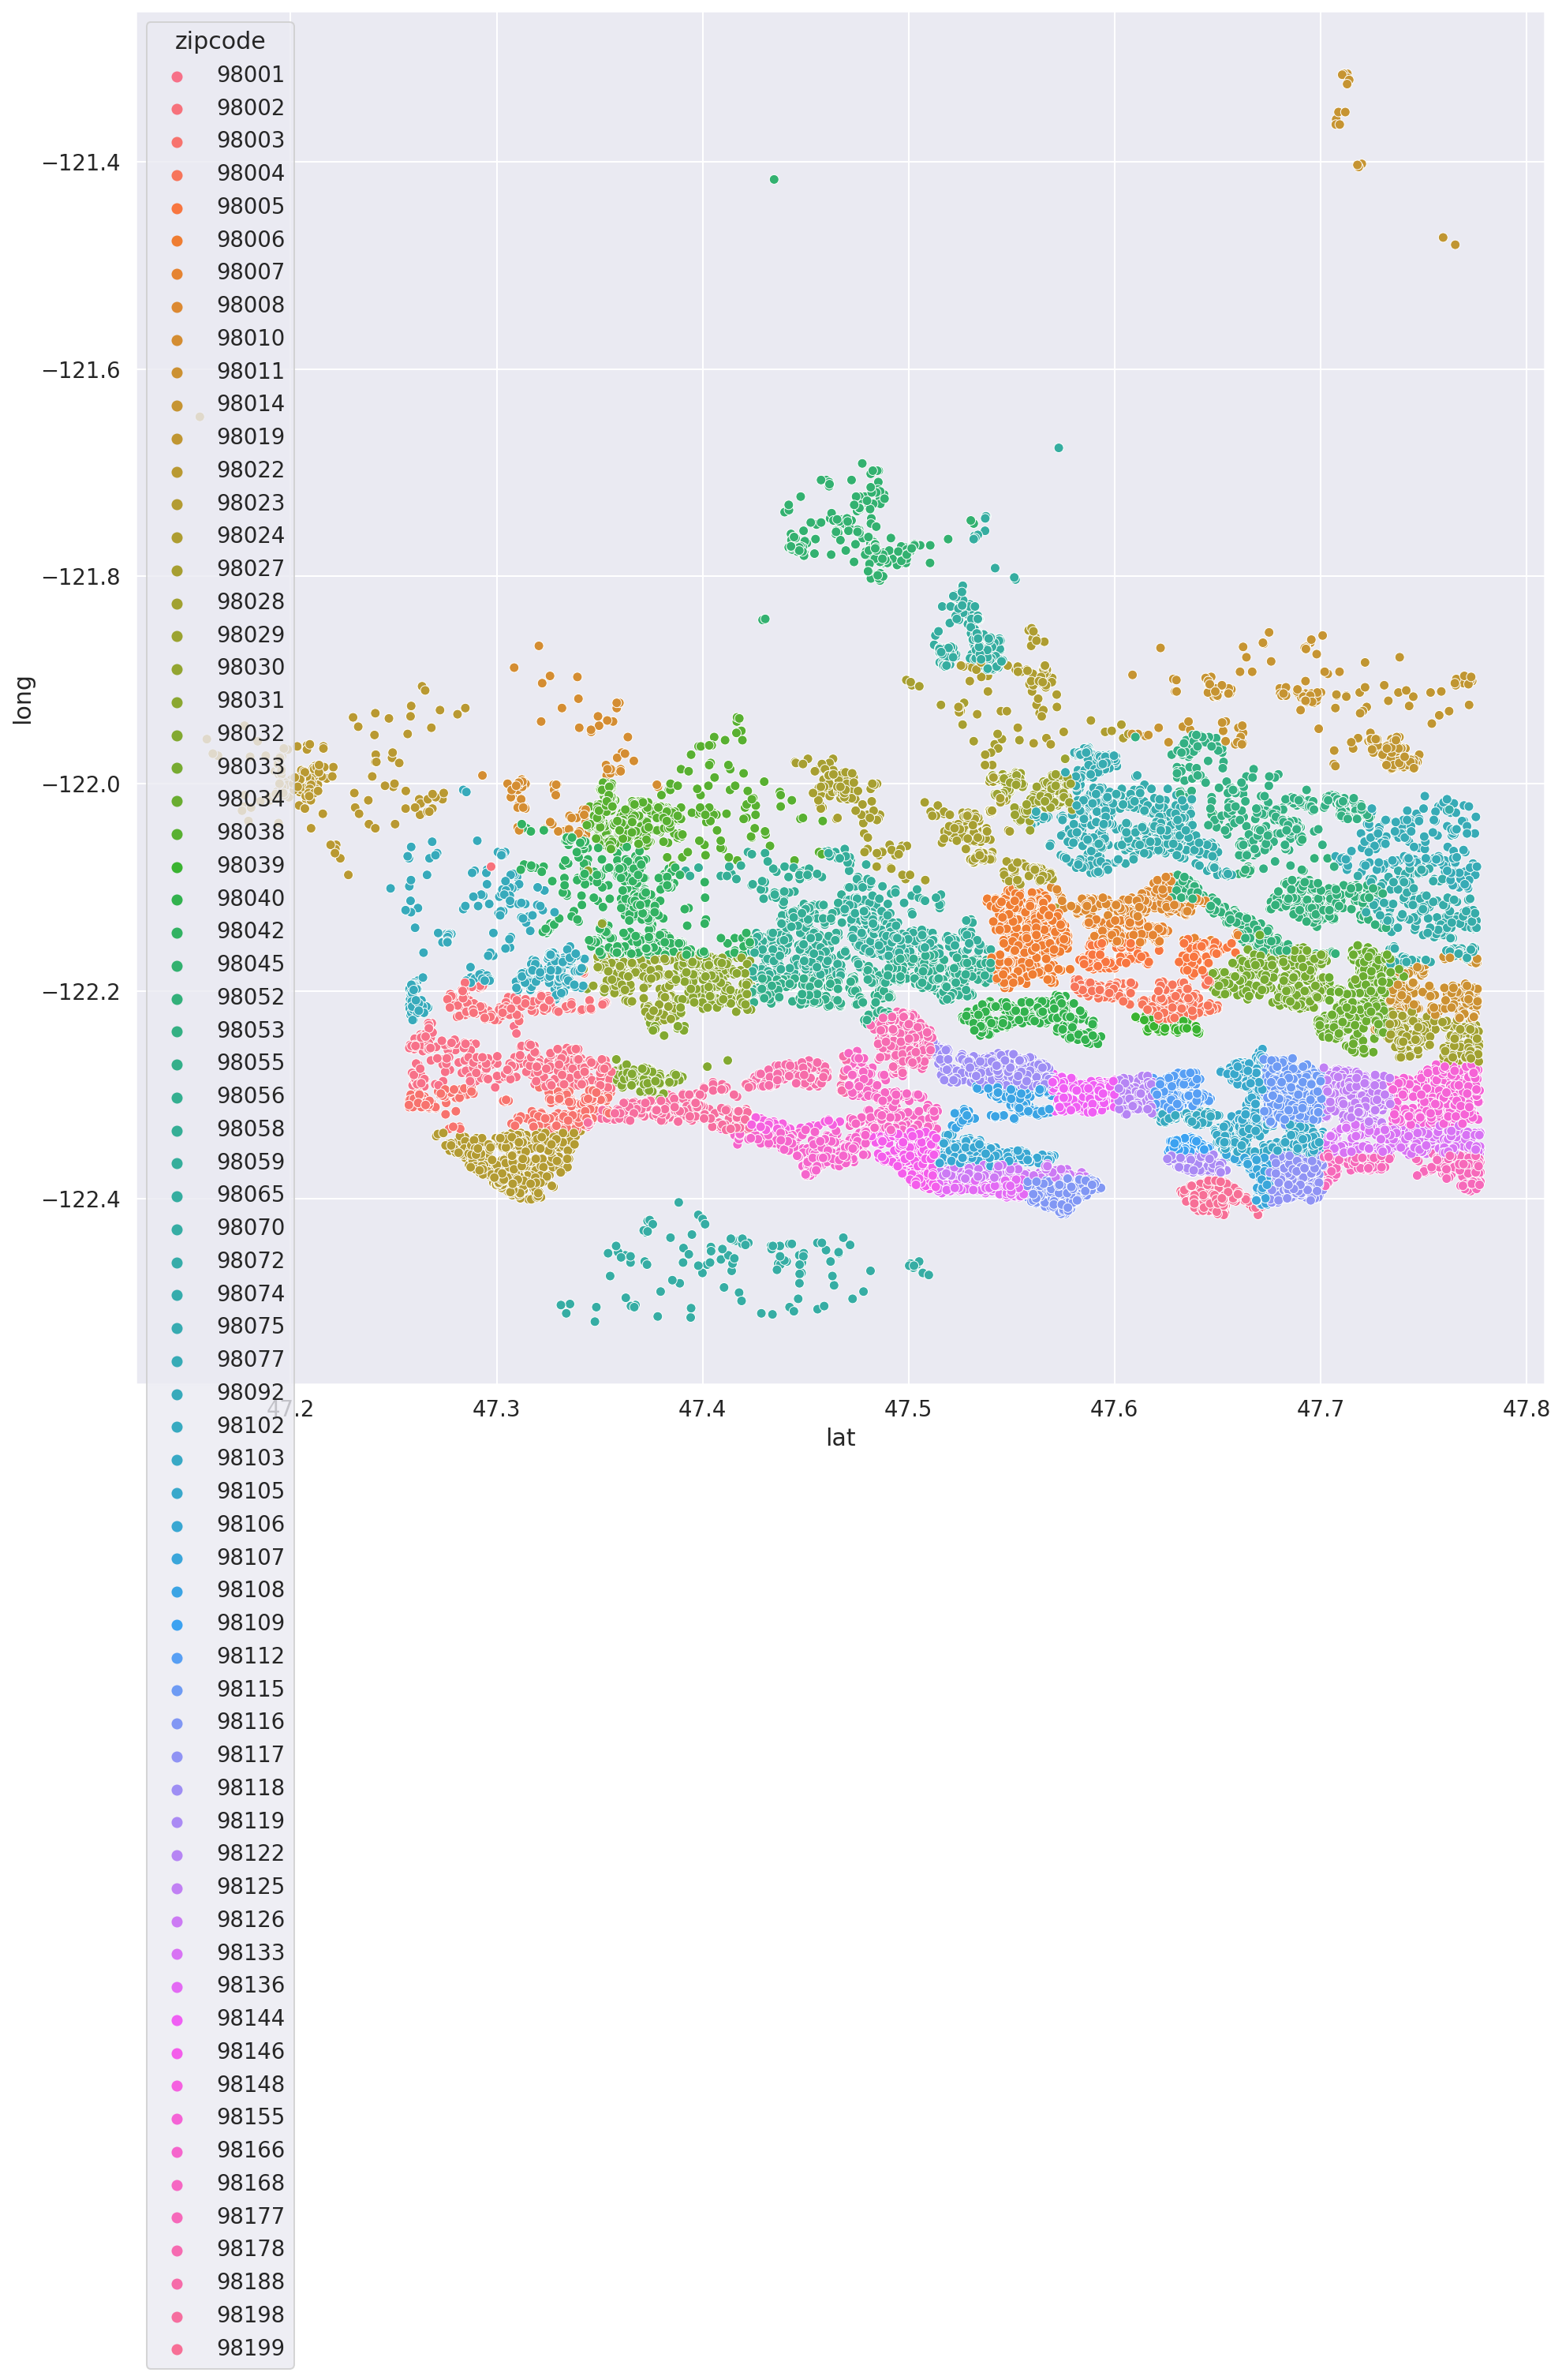

In [497]:
fig, ax = plt.subplots(figsize=(16, 16))
sns.scatterplot(data=data, x='lat', y='long', hue='zipcode', 
                hue_order=np.sort(data['zipcode'].unique()))


위치에 따른 집 가격의 분포에 대해서도 파악해봐야 할 것 같습니다.

#### (j) sqft_living15, sqft_lot15
sqft_living15는 각각 2015년 기준으로 주거공간의 면적 부지의 면적을 의미합니다. 15년 이후 재건축이 되어서 변화가 있는 지에 따라 값이 기존의 sqft_living, sqft_lot과 달라질 것으로 생각이 됩니다. 위에 분석에서 2014년에 재건축된 건물의 수가 크게 증가함에 따라 15년 이후를 기준으로 했다고 생각이 듭니다.

위에서 한 분석과 비슷한 분석을 우선 진행해 보겠습니다.

In [498]:
data['sqft_living15'].describe()

count    21503.000000
mean      1987.242664
std        685.579479
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2370.000000
max       6210.000000
Name: sqft_living15, dtype: float64

In [499]:
data['sqft_lot15'].describe()

count     21503.000000
mean      12774.529089
std       27334.995914
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10085.000000
max      871200.000000
Name: sqft_lot15, dtype: float64

<AxesSubplot:xlabel='sqft_lot15', ylabel='Count'>

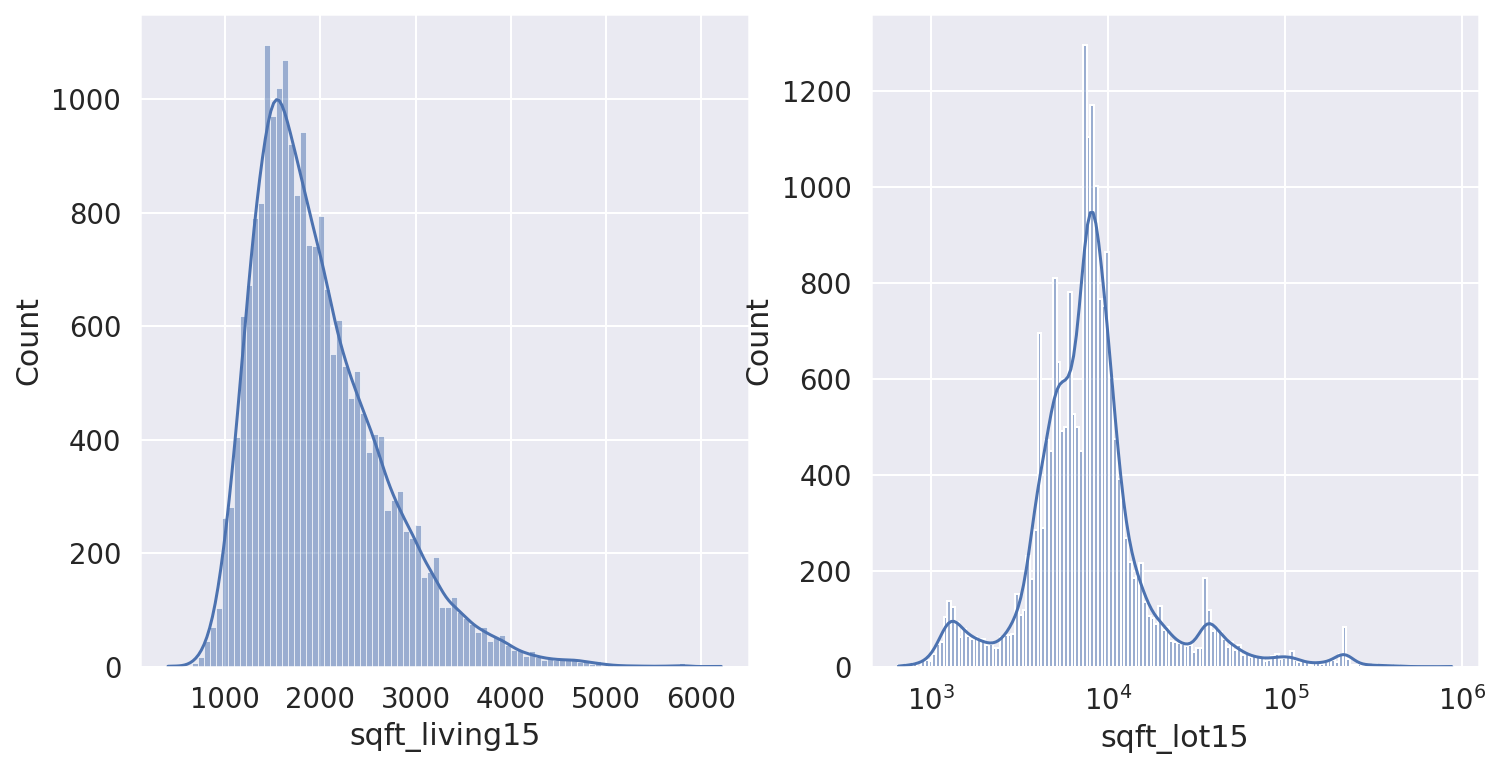

In [500]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

axs = axes.ravel()

sns.histplot(data=data, x='sqft_living15', kde=True, ax=axs[0])
sns.histplot(data=data, x='sqft_lot15', kde=True, log_scale=True, ax=axs[1])

재건축 후에는 많은 데이터가 1500~3000 부근에 몰려있는 것을 알 수 있습니다. 더 자세한 분석을 위해서는 sqft_living과 sqft_living15의 비교를 진행해봐야 알 수 있을 것 같습니다.

[]

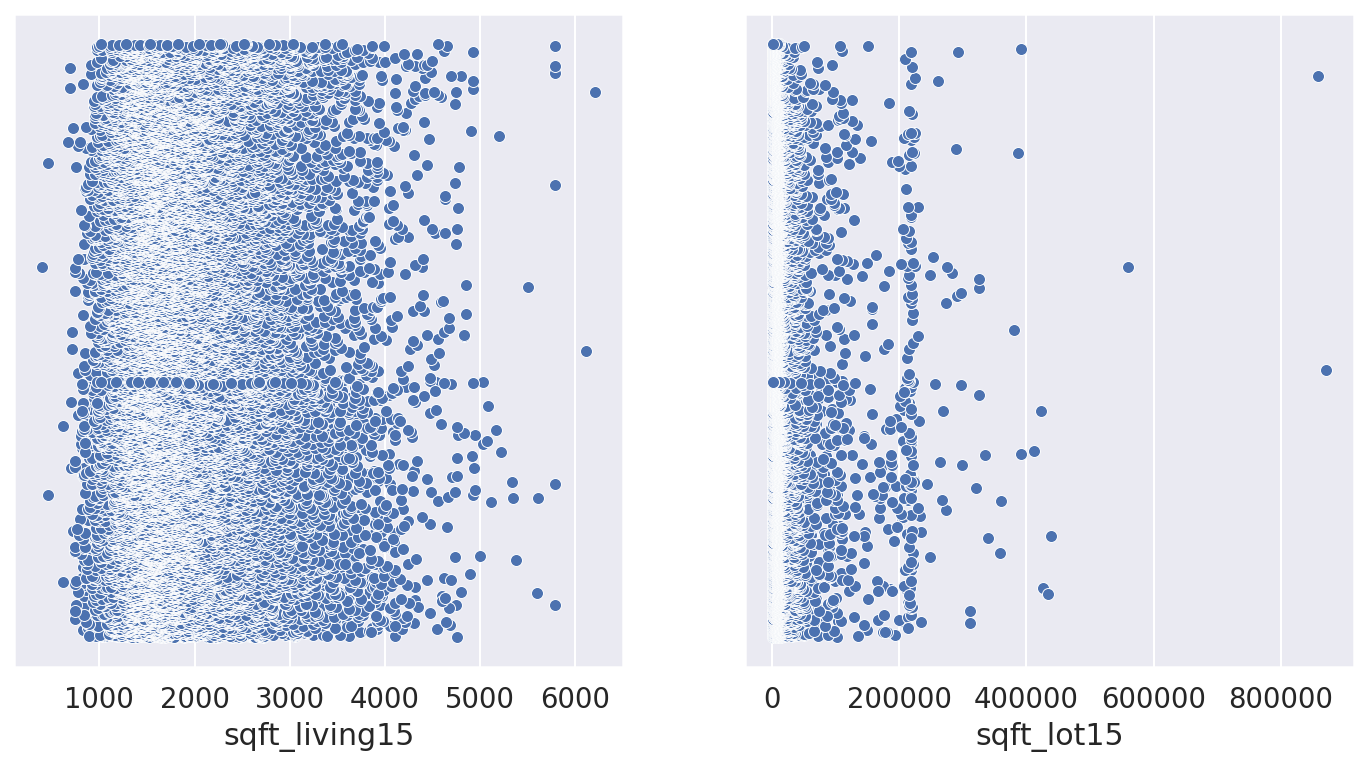

In [501]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
axs = axes.ravel()

sqft_living_data = data['sqft_living15']
sns.scatterplot(x=sqft_living_data.values, y=sqft_living_data.index, ax=axs[0])
axs[0].set_xlabel("sqft_living15")
axs[0].set_ylabel("")
axs[0].set_yticks([])

sqft_lot_data = data['sqft_lot15']
sns.scatterplot(x=sqft_lot_data.values, y=sqft_lot_data.index, ax=axs[1])
axs[1].set_xlabel("sqft_lot15")
axs[1].set_ylabel("")
axs[1].set_yticks([])

각각의 산점도를 통해서 sqft_living15의 경우에는 이상치가 많이 줄어들었다는 것을 확인할 수 있습니다. 반면에 sqft_lot15의 경우에는 이상치가 그대로 남아있는 모습을 볼 수 있습니다.

위에서 언급한대로 둘의 관계를 산점도를 통해서 살펴보았을 때도 유의미한 관계가 있다고 보기 힘들다는 것을 알 수 있습니다.

<AxesSubplot:xlabel='sqft_living15', ylabel='sqft_lot15'>

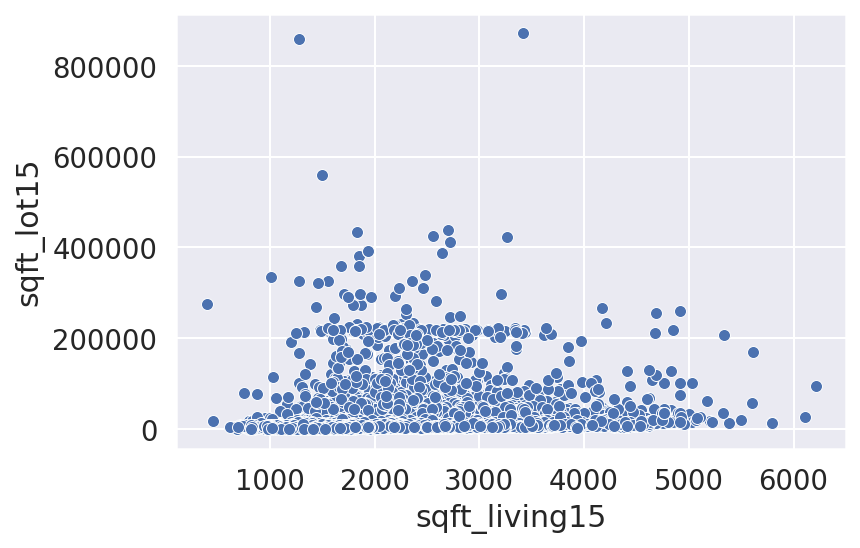

In [502]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x='sqft_living15', y='sqft_lot15')

sqft_living15와 sqft_living, yr_renovated에 대해서 좀 더 깊게 살펴보겠습니다. yr_renovated가 0이라 건물의 재건축이 이루어지지 않은 상태라면 sqft_living15와 sqft_living의 값이 같아야 할 것이라고 생각이 듭니다. 이에 관해 어떻게 데이터에 나와있는 지 살펴보겠습니다.

In [503]:
compare_living_data = data.loc[:, ['sqft_living', 'sqft_living15', 'yr_renovated']]
compare_living_data

sqft_living  sqft_living15  yr_renovated
0            1180           1340             0
1             770           2720             0
2            1680           1800             0
3            1715           2238             0
4            1060           1650             0
...           ...            ...           ...
6463         1500           1320             0
6464         1490           1400             0
6465         1310           1330             0
6466         1020           1020             0
6467         1600           1410             0

[21503 rows x 3 columns]

In [504]:
not_renovated_diff_df = compare_living_data.loc[(compare_living_data['yr_renovated']==0) & (compare_living_data['sqft_living'] != compare_living_data['sqft_living15'])]
not_renovated_diff_df

sqft_living  sqft_living15  yr_renovated
0            1180           1340             0
1             770           2720             0
2            1680           1800             0
3            1715           2238             0
4            1060           1650             0
...           ...            ...           ...
6462         3118           2673             0
6463         1500           1320             0
6464         1490           1400             0
6465         1310           1330             0
6467         1600           1410             0

[18106 rows x 3 columns]

In [505]:
not_renovated_diff_df['error_rate'] = (abs(not_renovated_diff_df['sqft_living'] - not_renovated_diff_df['sqft_living15']))\
                                      /(not_renovated_diff_df['sqft_living'])




In [506]:
not_renovated_diff_df['error_rate'].describe()

count    18106.000000
mean         0.226760
std          0.242530
min          0.000345
25%          0.070922
50%          0.161658
75%          0.303825
max          4.586207
Name: error_rate, dtype: float64

<AxesSubplot:xlabel='error_rate', ylabel='Count'>

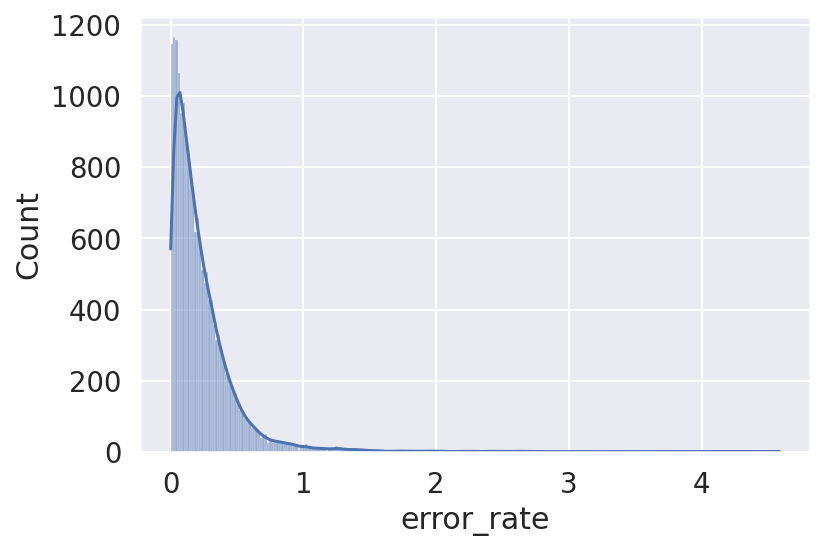

In [521]:
sns.histplot(data=not_renovated_diff_df, x='error_rate', kde=True)

다른 정보들을 찾아보니 sqft_living15, sqft_lot15 가 15년 재조사 결과가 아니고, 가까운 이웃 15개의 평균이라고 하는 글이 있네요!..

### (3) Relation between variables

개별 변수를 확인했으니 각 변수들간의 관계를 확인해보고 추가적인 변수를 더 만들어줄 수 있을지를 함께 생각해보겠습니다. 위에서 변수끼리 비교하는 부분에 추가적으로 분석을 진행해보겠습니다.

스피어만 순위 상관관계를 통해 살펴보도록 하겠습니다.

<AxesSubplot:>

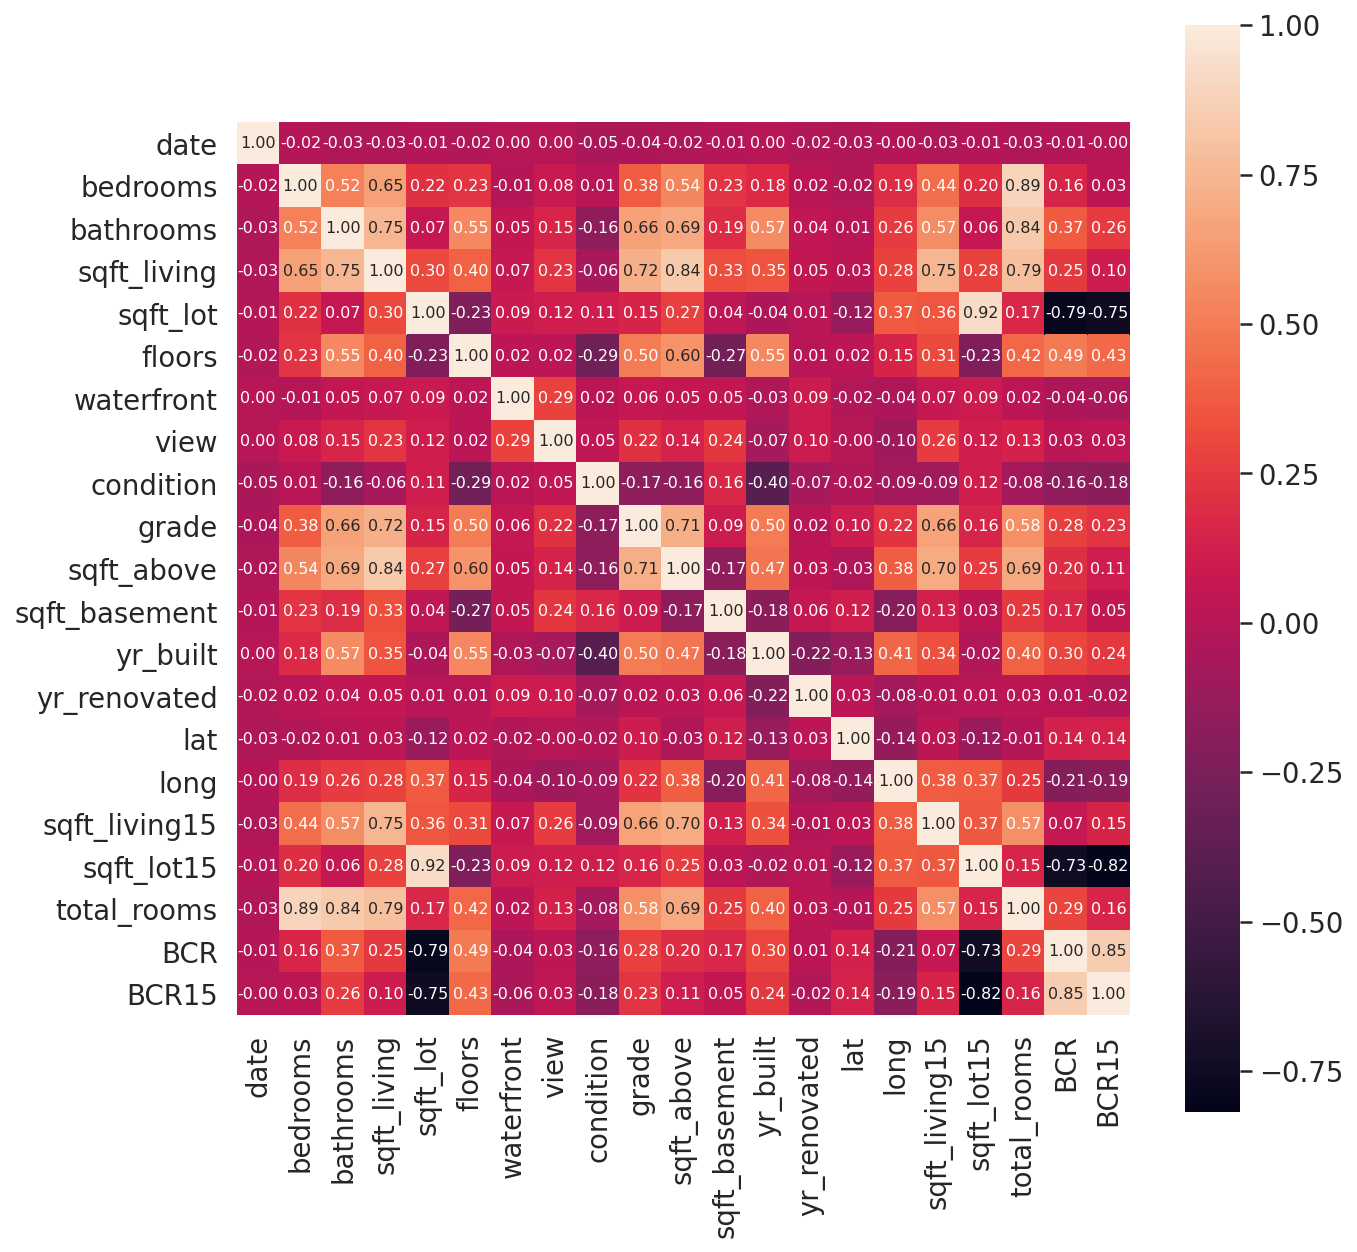

In [522]:
import scipy as sp

cor_mat = data.corr(method='spearman')
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cor_mat, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8})

생각했던대로 집 평수간의 연관성이 꽤 높은편이며, grade또한 평수와 양의 상관관계를 보이며, condition은 yr_built와 음의 상관관계를 보이는 등 비교적 생각한 바와 잘 맞아들어가는 모습을 볼 수 있습니다.

### (4) 각 변수들의 분포 확인

기본적인 개별 변수에 대한 분석을 어느정도 끝냈으니 각 변수들의 분포를 확인해 모델의 학습에 유리하도록 전처리를 해주겠습니다. seaborn의 kdeplot을 이용해 분포를 살펴보겠습니다.

그래프를 그려줄 때 `date` 컬럼에 대하여 datetime으로 형변환을 임의로 해주고 그리는 방식으로 구현을 하겠습니다. 이런 방법을 통해 데이터의 자료형은 건드리지 않고 필요에 따라 변환하여 그리는 방법을 선택했습니다.

[seaborn](https://seaborn.pydata.org/generated/seaborn.kdeplot.html)

In [523]:
data.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'BCR', 'BCR15'],
      dtype='object')

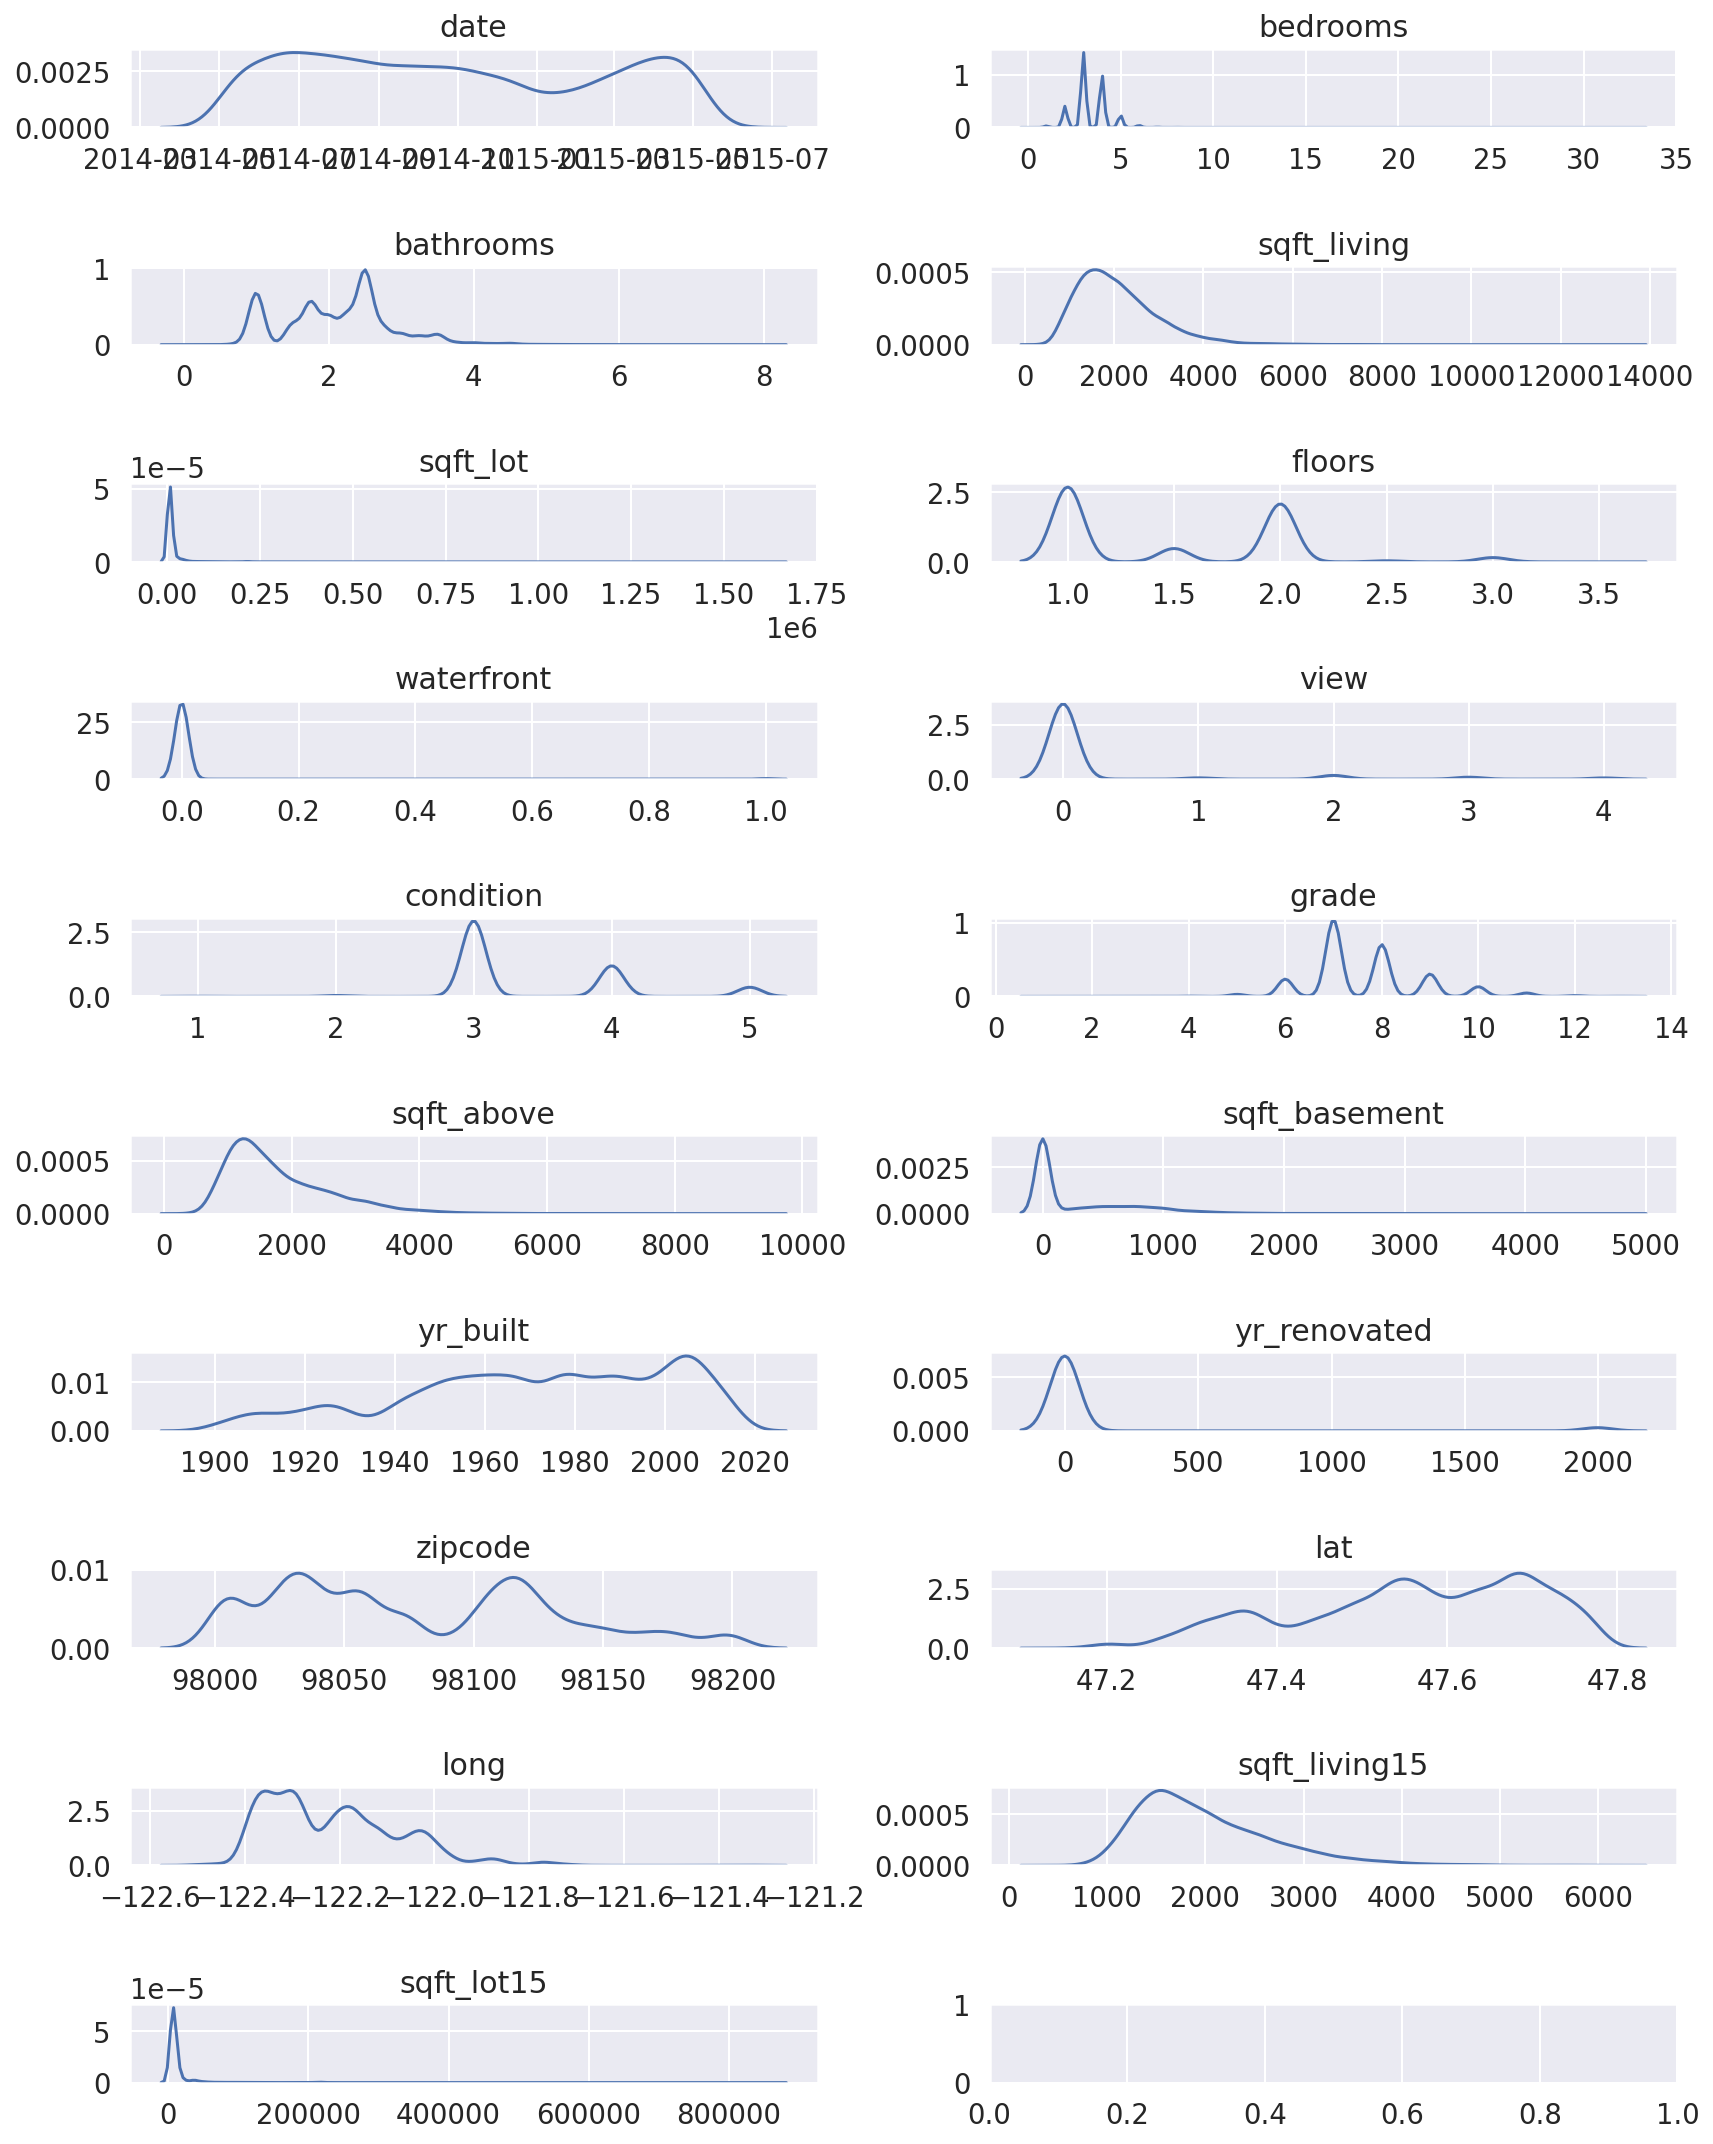

In [524]:
fig, axes = plt.subplots(10, 2, figsize=(12, 15))

axs = axes.ravel()
count = 0
columns = data.columns
for ax in axs:
    temp = data[columns[count]] 
    if count == 0:
        temp = pd.to_datetime(temp, format="%Y%m%d")
    if count == 14:
        temp = temp.astype(np.int64)
    sns.kdeplot(temp, ax=ax)
    
    ax.set_title(columns[count], fontsize=15)
    ax.set_xlabel("")
    ax.set_ylabel("")
    
    count += 1
    if count == 19:
        break
        
fig.tight_layout()      

#### (1) How to deal with __Skewed Data__?
데이터 분포 중 한쪽으로 지나치게 치우쳐져 있는 데이터에 대해 전처리를 해주겠습니다.

그래프를 보면 bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_lot, sqft_living15, sqft_lot15 변수가 한쪽으로 치우친 경향을 보였습니다. bedrooms는 제외?

In [548]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
                'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    print(f"{c} Skewness: {data['bedrooms'].skew()}")
    print(f"{c} Kurtosis: {data['bedrooms'].kurt()}\n")

    
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

bedrooms Skewness: 1.9833848228737991
bedrooms Kurtosis: 49.31206924083472

sqft_living Skewness: 1.9833848228737991
sqft_living Kurtosis: 49.31206924083472

sqft_lot Skewness: 1.9833848228737991
sqft_lot Kurtosis: 49.31206924083472

sqft_above Skewness: 1.9833848228737991
sqft_above Kurtosis: 49.31206924083472

sqft_basement Skewness: 1.9833848228737991
sqft_basement Kurtosis: 49.31206924083472

sqft_living15 Skewness: 1.9833848228737991
sqft_living15 Kurtosis: 49.31206924083472

sqft_lot15 Skewness: 1.9833848228737991
sqft_lot15 Kurtosis: 49.31206924083472



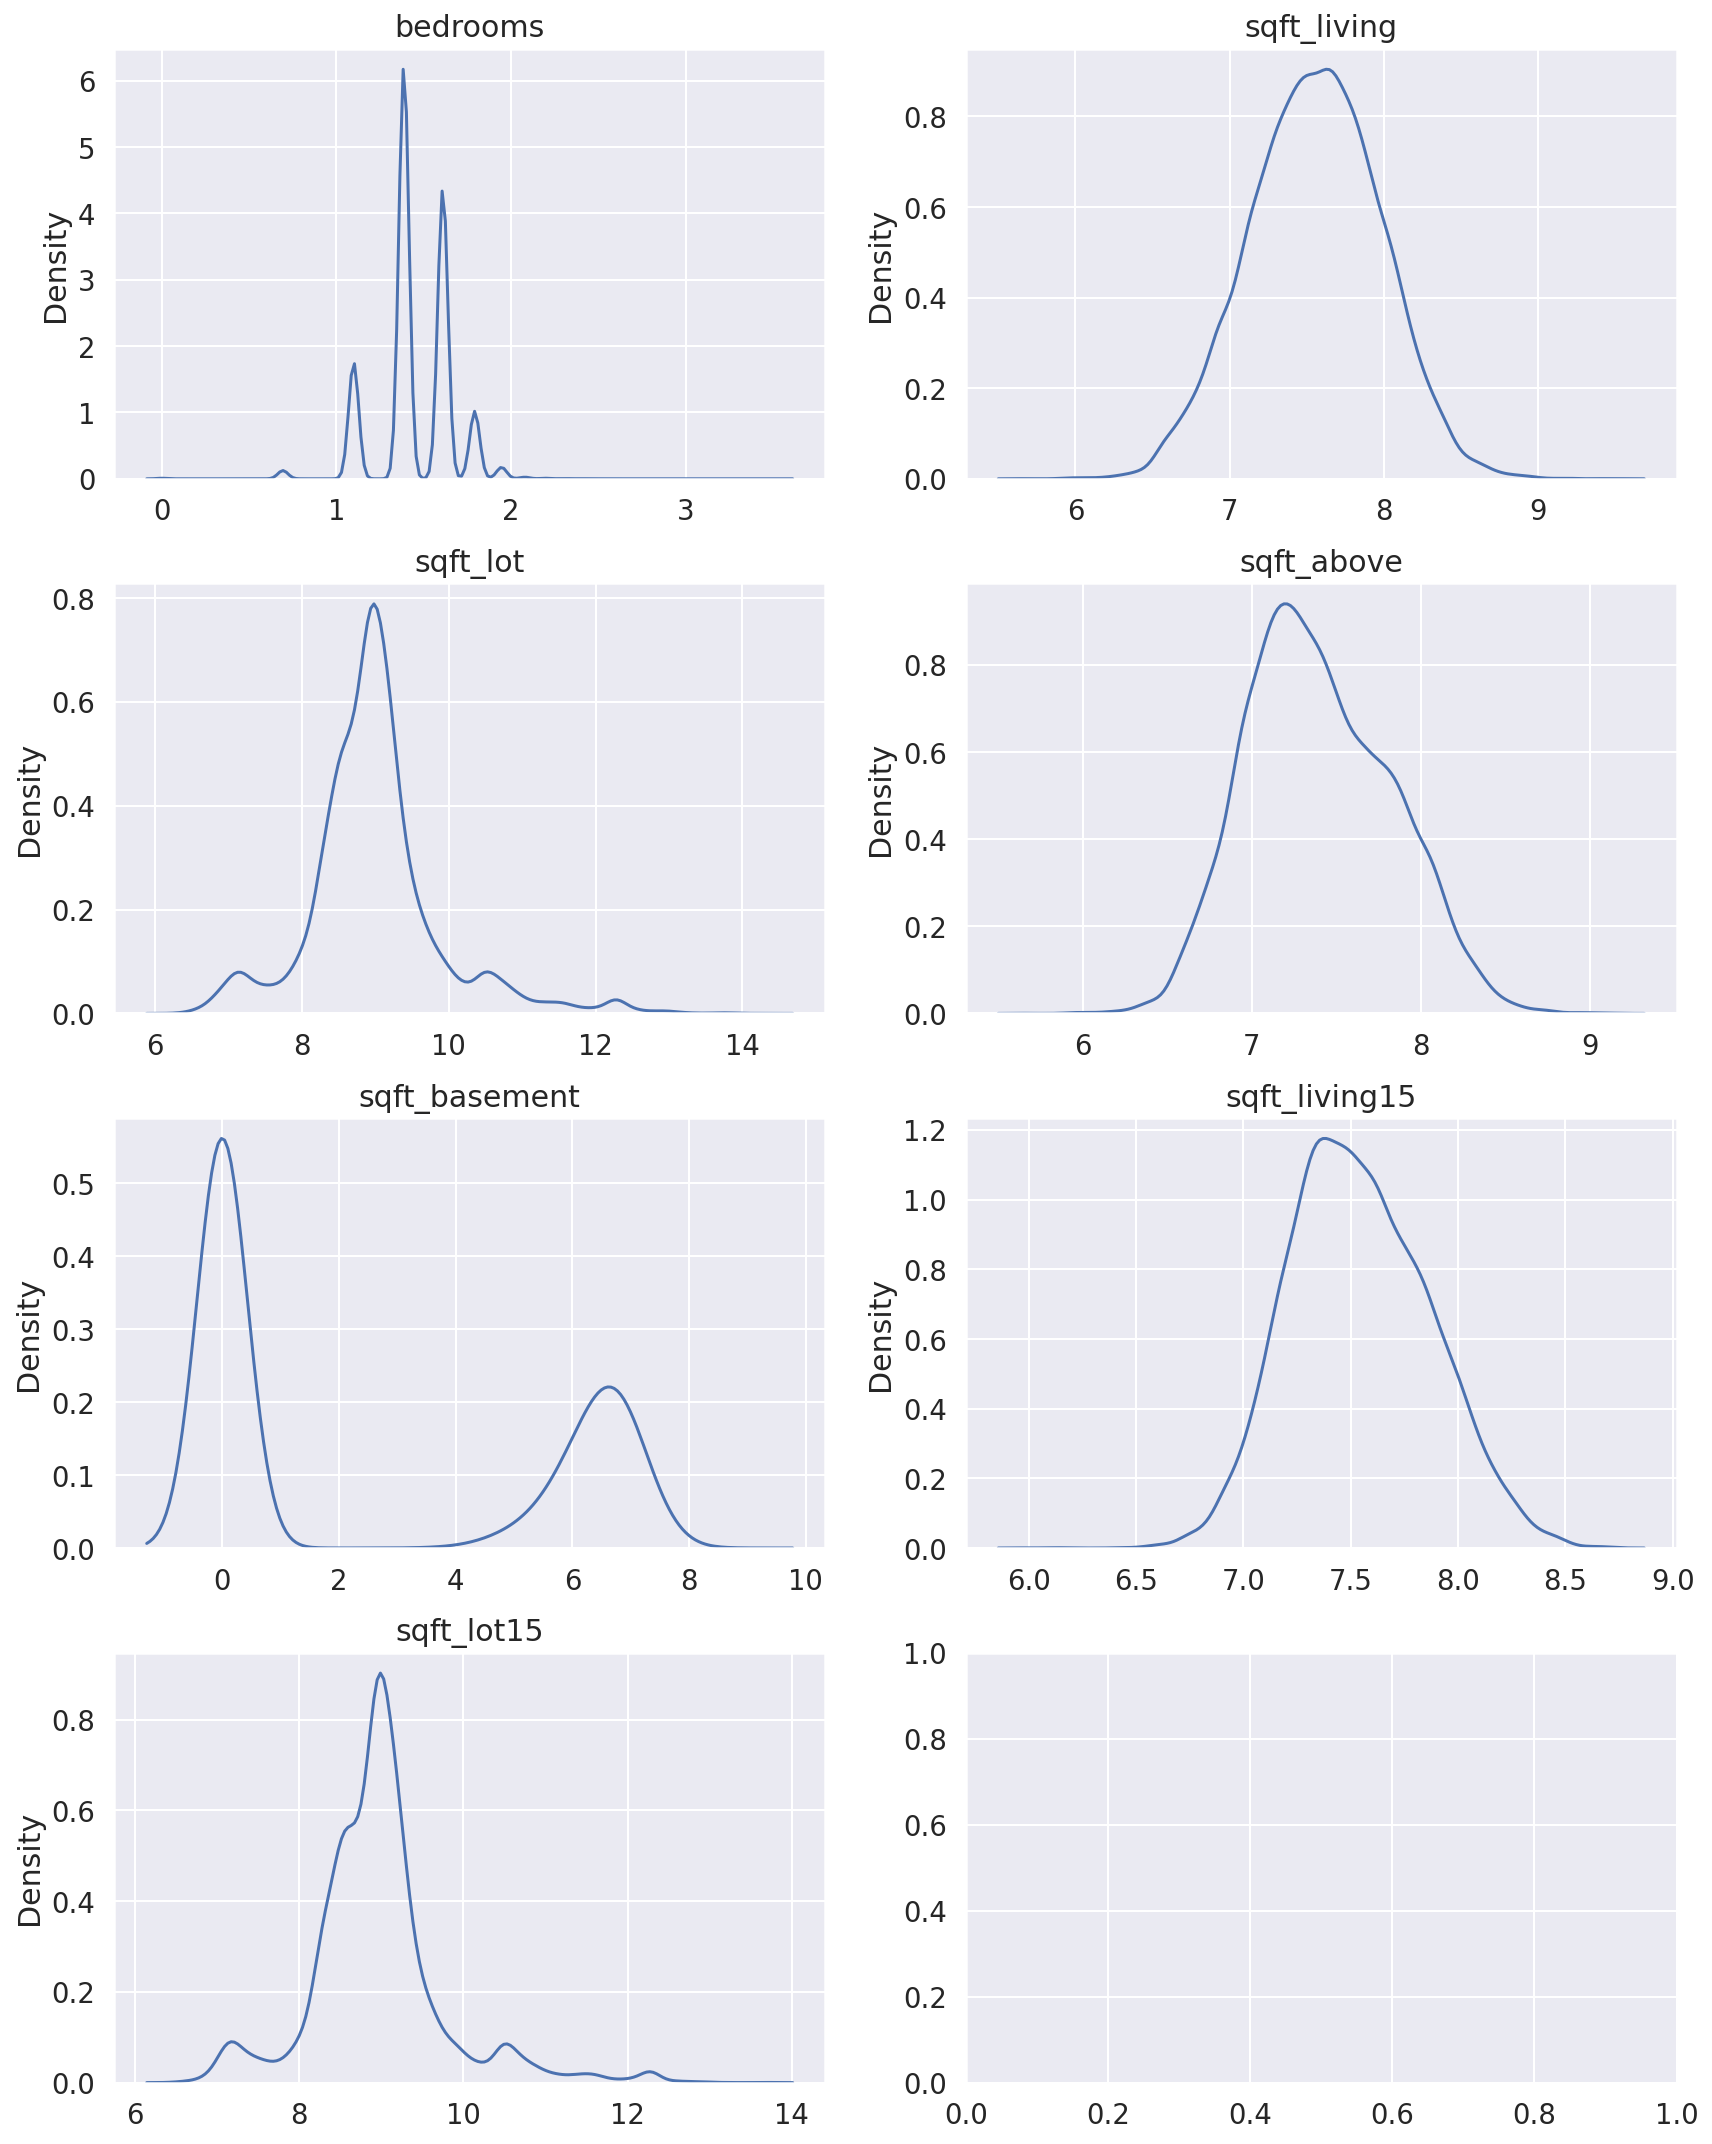

In [549]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 15))
axs = axes.ravel()
count = 0
for i, ax in enumerate(axs):
    if i == 7:
        break
    sns.kdeplot(data[skew_columns[i]], ax=ax)
    ax.set_xlabel("")
    ax.set_title(skew_columns[i], fontsize=15)
fig.tight_layout()

어느정도 치우침이 줄어들어 정규분포스러운 모습으로 바뀌었습니다. 여태 가만히 내비뒀던 가격(y)에 대해서도 살펴보겠습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

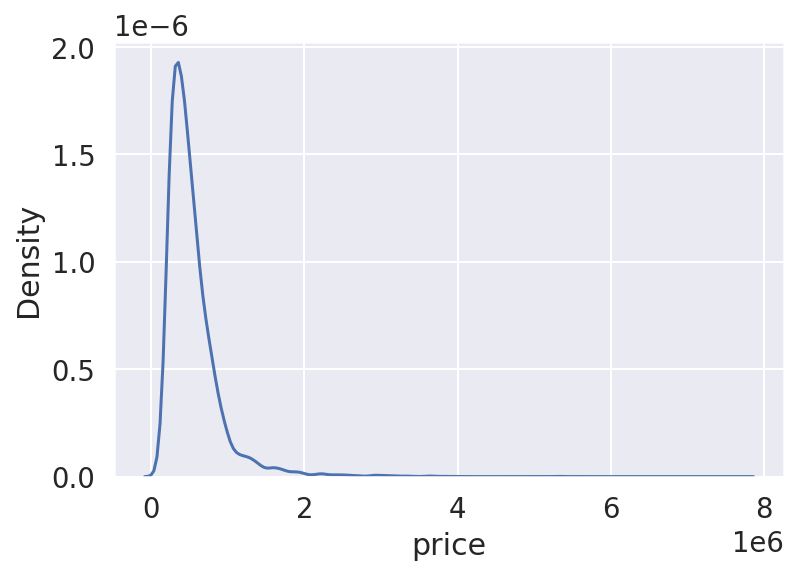

In [550]:
sns.kdeplot(y)

가격도 많이 치우쳐져 있어 log1p 변환을 통해 정규분포화 하겠습니다.

<AxesSubplot:xlabel='price', ylabel='Density'>

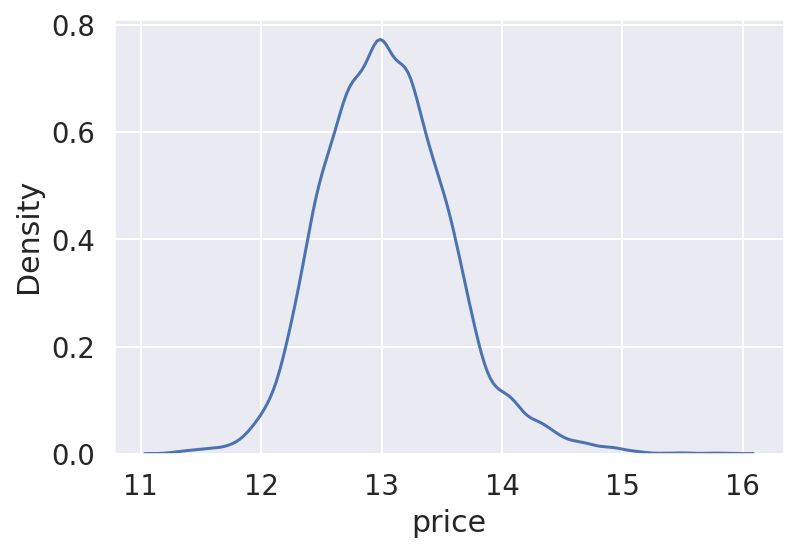

In [551]:
y = np.log1p(y)

sns.kdeplot(y)

### (5) 가격과의 상관관계 파악

가격값을 가지고 있는 train 데이터를 가지고 각 변수들이 가격과는 어떠한 상관관계가 있는 지 살펴보겠습니다. train_len을 이용해 train_data를 가져오고 다시 price를 concat해 `train_data_p`라는 데이터로 사용하겠습니다.

In [552]:
train_data = data[:train_len]
train_data_p = train_data.copy()
train_data_p['price'] = y ## concat으로 하면 왜 문제가 생길까?


print(data.shape)
print(train_len)
print(train_data_p.shape)

(21503, 22)
15035
(15035, 23)


In [553]:
train_data_p.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  20141013  1.386294       1.00     7.074117  8.639588     1.0           0   
1  20150225  1.098612       1.00     6.647688  9.210440     1.0           0   
2  20150218  1.386294       2.00     7.427144  8.997271     1.0           0   
3  20140627  1.386294       2.25     7.447751  8.827615     2.0           0   
4  20150115  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  ...  yr_renovated  zipcode      lat     long  \
0     0          3      7  ...             0    98178  47.5112 -122.257   
1     0          3      6  ...             0    98028  47.7379 -122.233   
2     0          3      8  ...             0    98074  47.6168 -122.045   
3     0          3      7  ...             0    98003  47.3097 -122.327   
4     0          3      7  ...             0    98198  47.4095 -122.315   

  sqft_living15  sqft_lot15  total_rooms       BCR     BCR15      price  
0      7.201171    8.639588         4.00  0.208850  0.237168  12.309987  
1      7.908755    8.995041         3.00  0.077000  0.337385  12.100718  
2      7.496097    8.923191         5.00  0.207921  0.239904  13.142168  
3      7.713785    8.827615         5.25  0.251503  0.328201  12.458779  
4      7.409136    9.181118         4.50  0.109155  0.169910  12.583999  

[5 rows x 23 columns]

다시 한번 스피어먼 순위 상관관계를 이용한 히트맵을 그려보겠습니다. 이 방식은 직접적으로 이 [커널](https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12)의 코드를 가져와 그렸습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'total_rooms' 'lat' 'bedrooms' 'floors']


<AxesSubplot:>

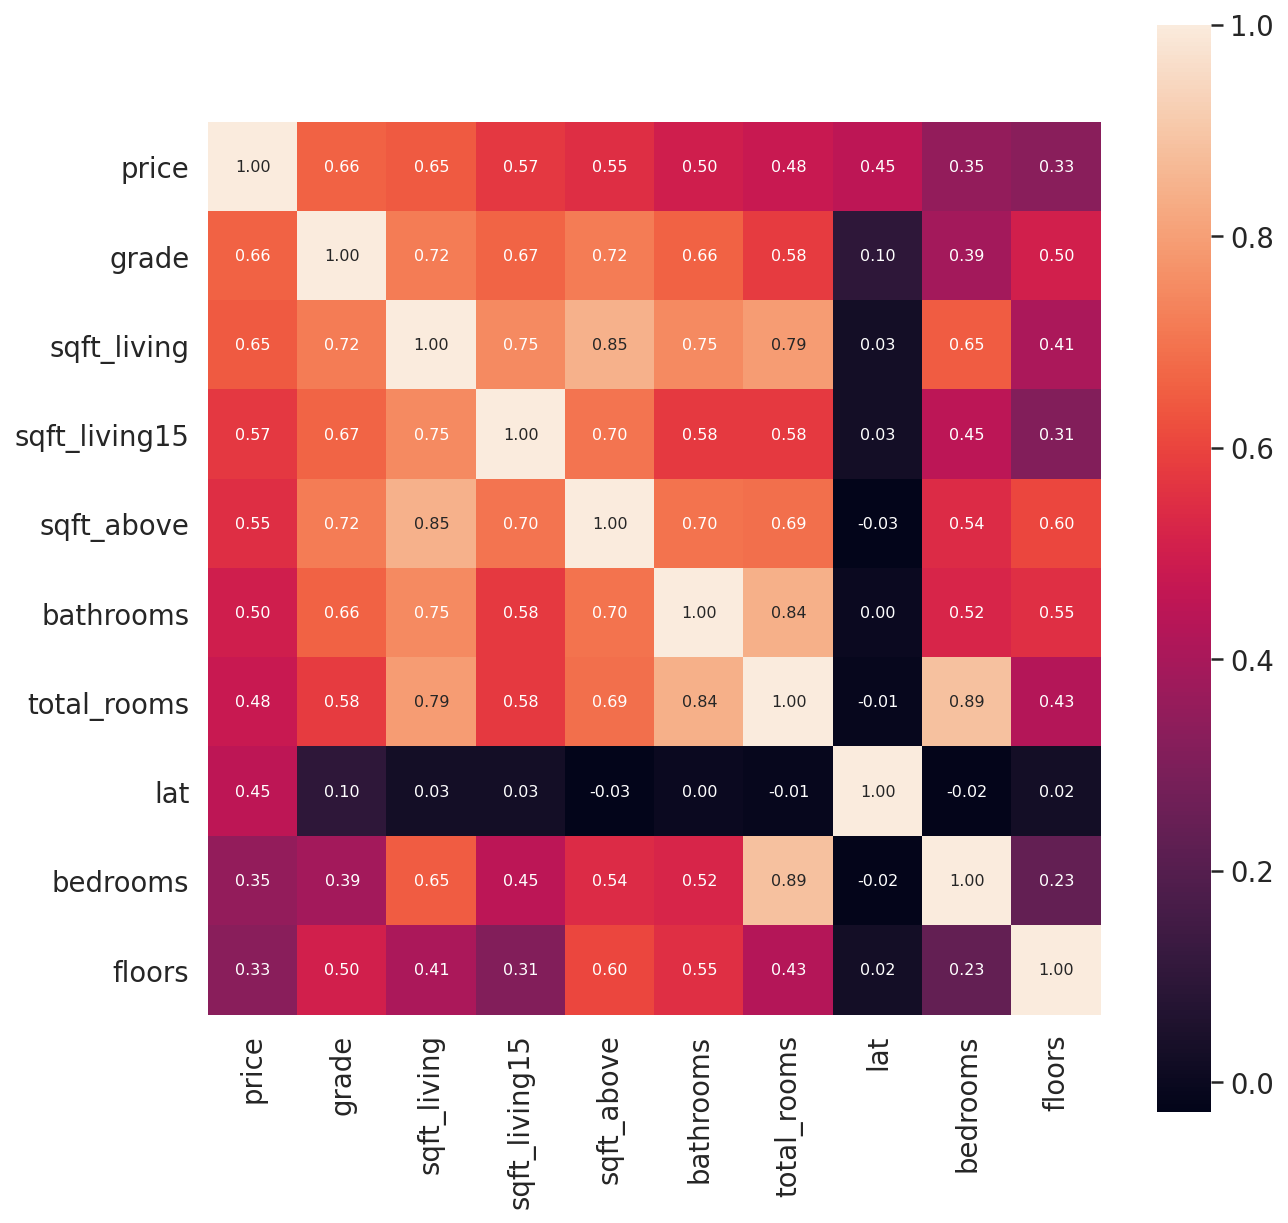

In [554]:
cor_abs = abs(train_data_p.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)

# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train_data_p[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

코드대로 가장 상관관계가 높은 10개를 뽑았을 때는 등급, 넓이(주거공간, 주거공간(15), 지하를 제외한 주거공간), 욕실, 위도 등의 순으로 중요하다고 나와있습니다. 따라서 가격과 관련이 높은 변수들을 가격과 하나씩 비교하며 분석해보겠습니다.

#### (1) grade-price

<AxesSubplot:xlabel='grade', ylabel='price'>

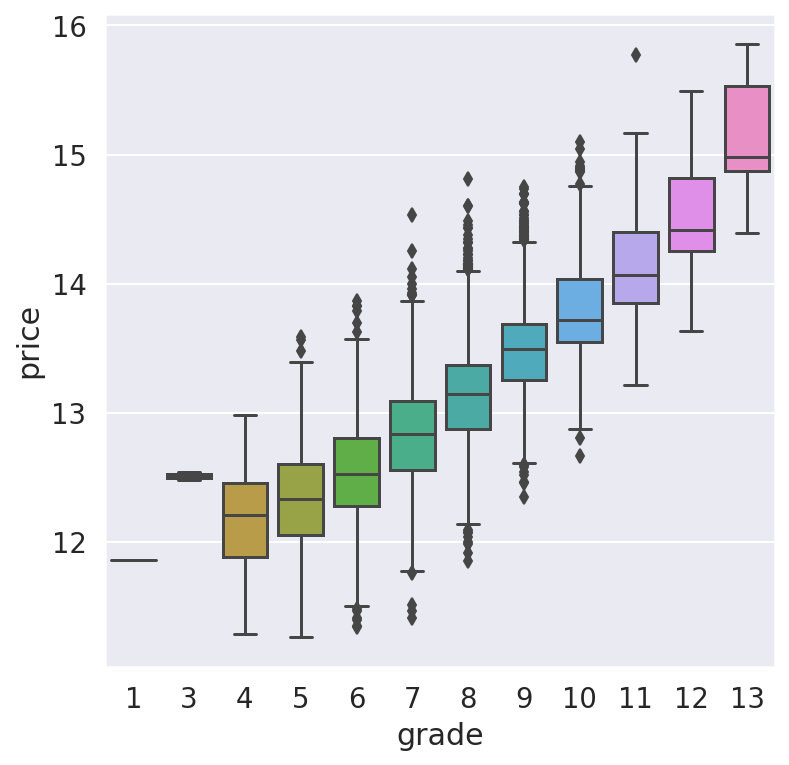

In [555]:
fig, ax = plt.subplots(figsize=(6,6))
grade_price_data = pd.concat([train_data_p['grade'], train_data_p['price']], axis=1)
sns.boxplot(data=grade_price_data, x='grade', y='price')

위에서 본 것과 같이 양의 상관관계를 띄고 있습니다. 눈 여겨봐야 하는 점을 몇개 살펴보겠습니다.

1. 개별 특성분석에서 봤듯이 2에 해당하는 값이 없습니다. 
2. 3에 해당하는 값은 상관관계와 달리 가격이 높습니다.
3. 6~10 에는 이상치가 꽤 많이 존재합니다.
4. 7, 8, 11에는 특별히 빠져나와있는 이상치도 존재합니다.

이에 대해 하나씩 살펴보겠습니다.

우선 grade는 넓이의 의미를 가진 sqft_ 류의 데이터와는 비교적 높은 상관관계를 가집니다. 따라서 sqft_ 류 특성이 가격에 큰 영향을 끼치지는 않았을 것이라 가정하고 그 다음으로 가격에 영향을 많이 끼치는 bathrooms, lat, bedrooms, floors, view을 살펴보겠습니다.

##### grade3 data

In [556]:
grade_3_data = train_data_p.loc[train_data_p['grade'] == 3]
print(f"There are {len(grade_3_data)} data with grade 3.")
print(f"Mean value of the number of bedrooms {np.expm1(grade_3_data['bedrooms'].mean())}")
print(f"Mean value of the number of bathrooms {(grade_3_data['bathrooms'].mean())}")
print(f"Mean value of the number of floors {(grade_3_data['floors'].mean())}")
print(f"Mean value of the view {(grade_3_data['view'].mean())}")

There are 2 data with grade 3.
Mean value of the number of bedrooms 1.0
Mean value of the number of bathrooms 0.375
Mean value of the number of floors 1.0
Mean value of the view 0.0


평균치를 통해 확인해봤을 때, 침실, 욕실, 층 수, view점수등이 영향을 끼쳤을 가능성은 없어보입니다. 위도에 해당하는 lat 값을 살펴보겠습니다. 

지금은 간단히 위도 값을 구하고 그 위도값을 가지는 데이터들의 평균 가격을 살펴보겠습니다. 추후에 위도, 경도등의 위치와 가격의 값을 살펴볼 때 더욱 유심히 살펴 볼 필요가 있습니다. 

In [557]:
grade_3_data['lat']

2302    47.2082
4123    47.5316
Name: lat, dtype: float64

In [558]:
lat1_data = train_data_p[train_data_p['lat'] == 47.2082]
lat1_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
2302  20150225  0.693147       0.75     6.255750  9.471319     1.0   
5489  20140729  1.609438       2.50     7.710205  9.047939     2.0   

      waterfront  view  condition  grade  ...  yr_renovated  zipcode      lat  \
2302           0     0          5      3  ...             0    98022  47.2082   
5489           0     0          3      8  ...             0    98022  47.2082   

         long sqft_living15  sqft_lot15  total_rooms       BCR     BCR15  \
2302 -121.995      7.201171    9.411974         1.75  0.040059  0.109540   
5489 -122.009      7.727976    9.079206         6.50  0.262353  0.258837   

          price  
2302  12.476104  
5489  12.691584  

[2 rows x 23 columns]

In [559]:
lat2_data = train_data_p[train_data_p['lat'] == 47.5316]
lat2_data.head()

date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  \
16     20140826  1.386294       2.75     8.023225  10.711480     1.0   
4123   20141104  0.693147       0.00     6.398595  10.106510     1.0   
8583   20140702  1.386294       1.75     7.893945   9.062536     1.0   
10311  20140710  1.609438       2.75     8.607217   9.809232     2.0   
15007  20140520  1.609438       3.50     8.029759   8.452121     2.0   

       waterfront  view  condition  grade  ...  yr_renovated  zipcode  \
16              0     4          3      9  ...             0    98040   
4123            0     0          2      3  ...             0    98045   
8583            0     0          5      8  ...             0    98027   
10311           1     4          3     11  ...             0    98118   
15007           0     0          3     10  ...             0    98027   

           lat     long sqft_living15  sqft_lot15  total_rooms       BCR  \
16     47.5316 -122.233      8.321422    9.920197         5.75  0.067979   
4123   47.5316 -121.749      6.898715   10.023490         1.00  0.024489   
8583   47.5316 -122.056      7.871311    9.566335         4.75  0.310725   
10311  47.5316 -122.263      8.194506    9.622516         6.75  0.300549   
15007  47.5316 -122.076      7.736744    7.887959         7.50  0.655423   

          BCR15      price  
16     0.202105  14.508658  
4123   0.043904  12.542548  
8583   0.183538  13.262127  
10311  0.239735  14.293297  
15007  0.859610  13.573440  

[5 rows x 23 columns]

이를 통해 살펴보면 경도는 모두 다르지만 해당 위도에서는 대부분 grade가 8이상이며 가격 또한 높게 형성되있음을 볼 수 있습니다. 집 가격이 주변 시세에 따라 비슷하게 형성된다는 점을 고려해보면 이해가 가는 부분이며, __'주위의 평균 집 가격'__ 이라는 정보가 꽤나 중요한 역할을 할 것이라는 것을 알 수 있습니다.

##### grade 6 ~ 10 data

grade 6 ~ 10 를 가지는 데이터 중에 이상치를 가지는 데이터가 꽤 많은데 이를 각 데이터마다 lat을 구하고 그 위도에서 평균적으로 grade가 어떻게 되는 지 살펴보겠습니다.

우선 일반적인 6~10 사이의 데이터는 아래와 같습니다.

<AxesSubplot:xlabel='lat', ylabel='price'>

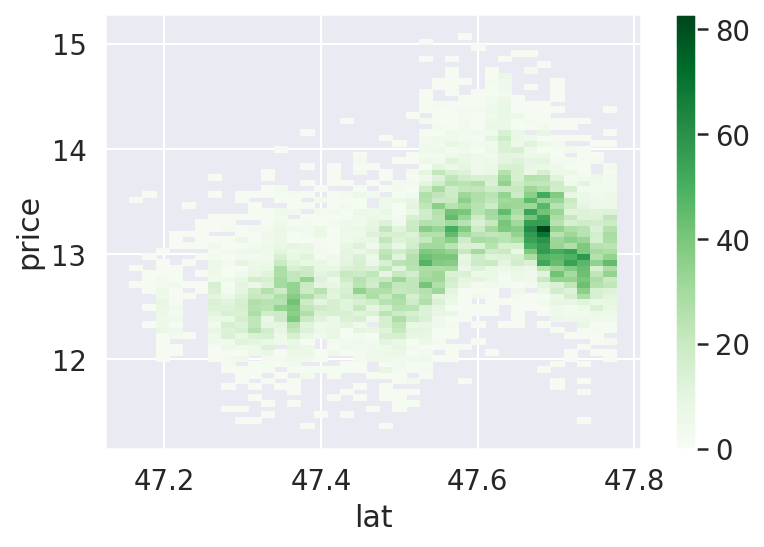

In [560]:
grade_mid_data = train_data_p.loc[(train_data_p['grade'] >= 6) & (train_data_p['grade'] <= 10)]

fig, ax = plt.subplots()
cmap = "Greens"
sns.histplot(data=grade_mid_data, x='lat', y='price', ax=ax, cbar=True, cmap=cmap)

<AxesSubplot:xlabel='lat', ylabel='avg_grade'>

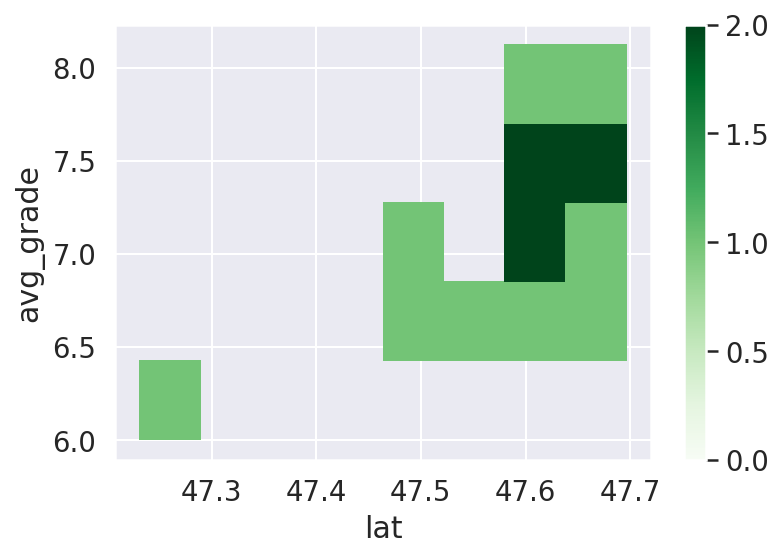

In [561]:
grade_six_data = train_data_p.loc[(train_data_p['grade'] == 6)]

ulimit = np.percentile(grade_six_data.price.values, 99)
llimit = np.percentile(grade_six_data.price.values, 1)

ulimit_six = grade_six_data.loc[grade_six_data['price'] >= ulimit]
ulimit_lat = ulimit_six['lat'].to_numpy()

results = pd.DataFrame()
results['lat'] = ulimit_lat

avg_price = []
avg_grade = []

for lat in ulimit_lat:
    temp = train_data_p[train_data_p['lat'] == lat]
    avg_price.append(temp['price'].mean())
    avg_grade.append(temp['grade'].mean())

results['avg_price'] = avg_price
results['avg_grade'] = avg_grade

# display(results)

fig, ax = plt.subplots()
cmap = "Greens"
sns.histplot(data=results, x='lat', y='avg_grade', ax=ax, cbar=True, cmap=cmap)

<AxesSubplot:xlabel='lat', ylabel='avg_grade'>

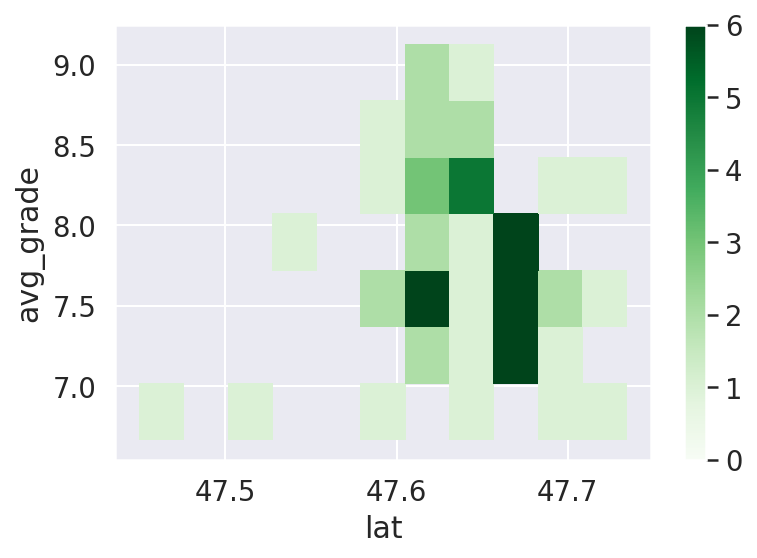

In [562]:
grade_seven_data = train_data_p.loc[(train_data_p['grade'] == 7)]

ulimit = np.percentile(grade_seven_data.price.values, 99)
llimit = np.percentile(grade_seven_data.price.values, 1)

ulimit_seven = grade_seven_data.loc[grade_seven_data['price'] >= ulimit]
ulimit_lat = ulimit_seven['lat'].to_numpy()

results = pd.DataFrame()
results['lat'] = ulimit_lat

avg_price = []
avg_grade = []

for lat in ulimit_lat:
    temp = train_data_p[train_data_p['lat'] == lat]
    avg_price.append(temp['price'].mean())
    avg_grade.append(temp['grade'].mean())

results['avg_price'] = avg_price
results['avg_grade'] = avg_grade

# display(results)

fig, ax = plt.subplots()
cmap = "Greens"
sns.histplot(data=results, x='lat', y='avg_grade', ax=ax, cbar=True, cmap=cmap)

위와 같이 확인 가능하며 몇몇 데이터는 쉽게 시각화를 통해서 볼 수 없지만, 위와 같은 방법으로 확인할 수 있습니다. (추후에 추가로 할 것)

##### 3. grade 8, 11


In [563]:
grade_eight_data = train_data_p.loc[(train_data_p['grade'] == 8)]
idx = grade_eight_data['price'].argmax()
max_eight = grade_eight_data.iloc[idx]
print(max_eight['bathrooms'] - grade_eight_data['bathrooms'].mean())

grade_ten_data = train_data_p.loc[(train_data_p['grade'] == 10)]
idx = grade_ten_data['price'].argmax()
max_ten = grade_ten_data.iloc[idx]
print(max_ten['view'] - grade_ten_data['view'].mean())

1.6539695745186593
3.3610755441741356


In [564]:
max_eight['lat']
lat1_data = train_data_p[train_data_p['lat'] == max_eight['lat']]
lat1_data

date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  \
2395   20150416  1.386294       1.00     7.353082   8.249575     1.5   
5866   20150121  1.386294       1.75     6.792344   8.243019     1.5   
7046   20141028  1.098612       2.25     7.163172   7.798523     2.0   
7173   20140813  1.791759       4.00     8.350194  10.214495     2.0   
9692   20140926  1.098612       1.00     6.781058   8.424859     1.0   
12930  20140905  1.609438       1.75     7.937732   8.594339     1.0   

       waterfront  view  condition  grade  ...  yr_renovated  zipcode  \
2395            0     0          3      8  ...             0    98117   
5866            0     0          3      7  ...             0    98115   
7046            0     0          3      7  ...             0    98052   
7173            1     4          3      8  ...          1985    98033   
9692            0     0          3      7  ...             0    98115   
12930           0     0          3      9  ...          2006    98115   

           lat     long sqft_living15  sqft_lot15  total_rooms       BCR  \
2395   47.6803 -122.387      7.438972    8.537192         4.00  0.407843   
5866   47.6803 -122.291      7.155396    8.243019         4.75  0.234211   
7046   47.6803 -122.156      7.215975    8.035603         4.25  0.529557   
7173   47.6803 -122.214      7.886457   10.214495         9.00  0.154973   
9692   47.6803 -122.287      7.223296    8.564840         3.00  0.193067   
12930  47.6803 -122.313      7.307202    8.594339         5.75  0.518519   

          BCR15      price  
2395   0.333333  13.710151  
5866   0.336842  13.028055  
7046   0.440415  12.660331  
7173   0.097454  14.808763  
9692   0.261301  12.936036  
12930  0.275926  13.668171  

[6 rows x 23 columns]

In [565]:
lat2_data = train_data_p[train_data_p['lat'] == max_ten['lat']]
lat2_data

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
2049   20141118  1.386294       3.25     8.521384  9.428029     2.0   
3672   20150416  1.609438       2.50     8.245647  8.952735     2.0   
4558   20140709  1.609438       1.75     7.601402  8.291296     1.0   
10791  20150302  1.098612       1.50     6.710523  7.147559     2.0   
14103  20150328  1.098612       1.50     6.888572  6.749931     2.0   
14490  20140919  1.098612       2.75     7.576097  7.384610     3.0   
15011  20140623  1.098612       1.50     6.846943  7.478170     2.0   

       waterfront  view  condition  grade  ...  yr_renovated  zipcode  \
2049            1     4          3     10  ...          2002    98144   
3672            0     0          3      9  ...             0    98074   
4558            0     4          4      7  ...             0    98116   
10791           0     0          3      7  ...             0    98144   
14103           0     0          3      7  ...             0    98144   
14490           0     0          3      8  ...             0    98144   
15011           0     0          3      7  ...             0    98144   

           lat     long sqft_living15  sqft_lot15  total_rooms       BCR  \
2049   47.5925 -122.287      8.210940    9.443117         6.25  0.403829   
3672   47.5925 -122.058      8.098947    8.952735         6.50  0.493012   
4558   47.5925 -122.391      7.433075    8.329658         5.75  0.501505   
10791  47.5925 -122.295      7.030857    7.091742         3.50  0.645669   
14103  47.5925 -122.295      7.030857    7.147559         3.50  1.148886   
14490  47.5925 -122.302      6.814543    7.465083         4.75  1.211180   
15011  47.5925 -122.295      7.030857    7.056175         3.50  0.531674   

          BCR15      price  
2049   0.291601  15.096445  
3672   0.425725  13.685403  
4558   0.407819  13.604791  
10791  0.940883  12.807655  
14103  0.889764  12.842652  
14490  0.521490  13.226725  
15011  0.974978  12.800783  

[7 rows x 23 columns]

이 경우는 이상치를 위도와 관련해서 볼 수는 없었지만 각각 평균보다 욕실의 수가 많거나 view 점수가 높음을 알 수 있습니다.

#### sqft_living, sqft_living15, sqft_above

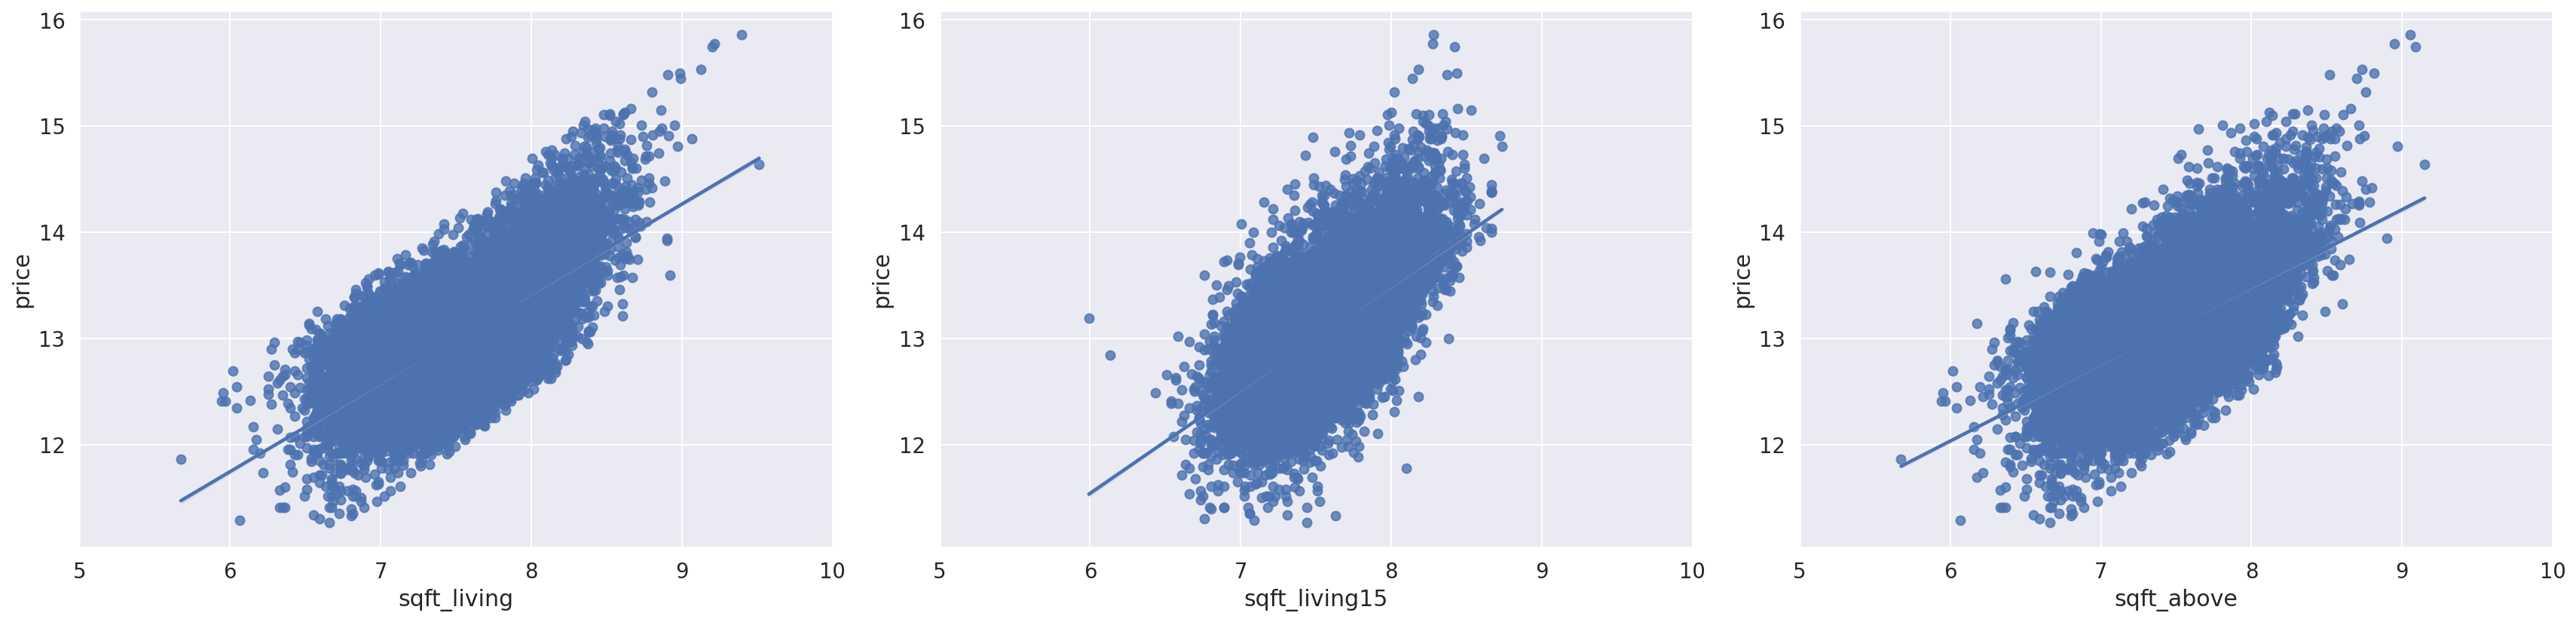

In [566]:
sqft_cols = ['sqft_living', 'sqft_living15', 'sqft_above']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
axs = axes.ravel()
for i, col in enumerate(sqft_cols):
    sns.regplot(x=col, y="price", data=train_data_p, ax=axs[i])
    axs[i].set_xlim(5, 10)
fig.tight_layout()

이미 둘 다 로그 변환을 취한 뒤라서 그런지 딱히 처리해줘야 할 이상치 값은 눈에 보이지 않습니다. sqft_living15의 경우 sqft에 비해 오밀조밀하게 보이는데 이는 주변 15개 지역의 평균임을 고려하면 충분히 설득력있는 그림이라고 볼 수 있습니다.

#### bathrooms, bedrooms, floors, view

위와 같은 이산데이터에 관해서는 한번에 각각에 대한 boxplot을 그려 확인해보겠습니다.

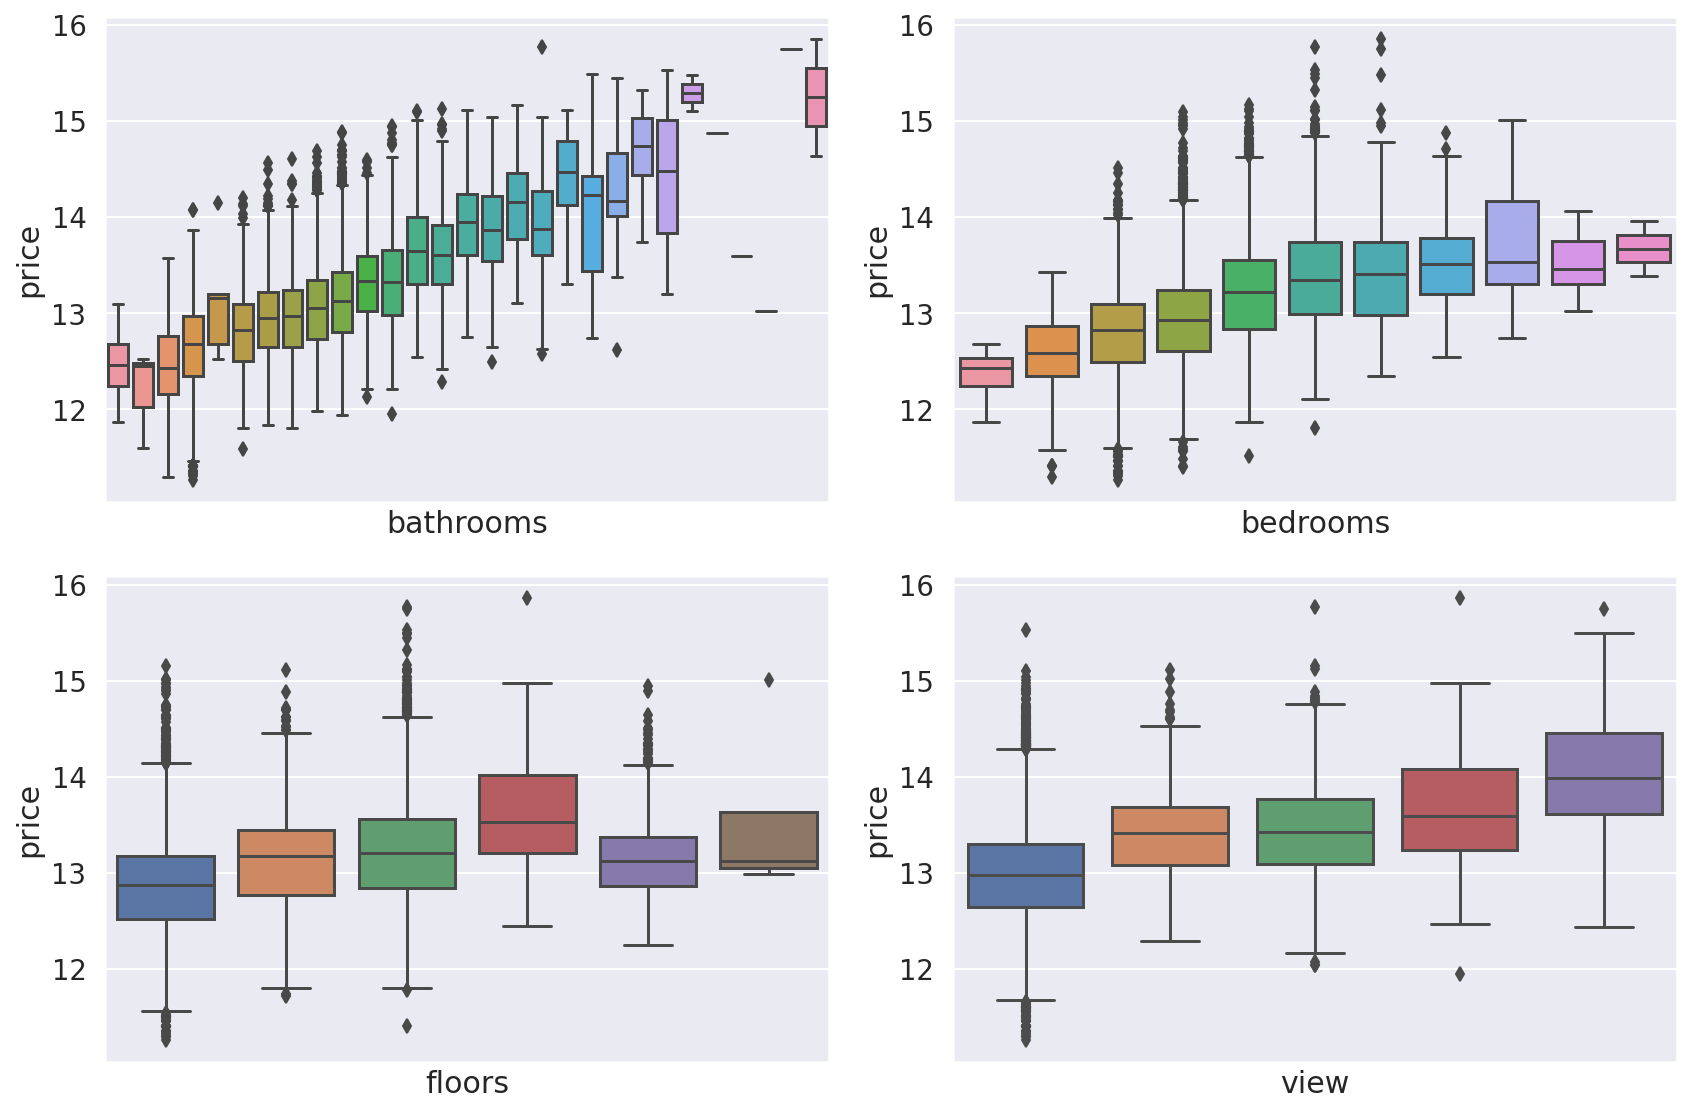

In [567]:
disc_cols = ['bathrooms', 'bedrooms', 'floors', 'view']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axs = axes.ravel()
for i, col in enumerate(disc_cols):
    sns.boxplot(x=col, y="price", data=train_data_p, ax=axs[i])
    axs[i].set_xticks([])
fig.tight_layout()

모두 boxplot을 통해 분포를 살펴 보았을 때 가격의 상관성이 대략 눈에 보입니다. 이 때도 이상치는 위도나 기타 요소와 관련이 높을 가능성이 높습니다. (이는 각 변수와 상관이 낮은 변수중에서 가격과 상관이 높은 변수를 생각해보면 위도가 가장 가능성이 높기 때문입니다.)

## 3. Feature Engineering

위에서 EDA에 곁들여 전처리를 진행했을 때는 현재는 욕실의 갯수가 13개인 데이터를 제외해준 것, 분포에 대해 log를 씌워준 것이 있습니다. 이에 추가로 특성을 더 해 모델의 학습효과를 높일 수 있는 지 생각해보며 특성을 추가해보겠습니다.

### (1) Additional Feature - 주거 구조 특성

1. 각 집에 해당하는 전체 방 갯수를 구해 특성으로 추가해줄 수 있습니다. 이는 bedroooms의 갯수 + bathrooms의 갯수로 간단히 이뤄질 수 있습니다.

2. 전체 부지에서 주거공간의 비율(건폐율)(BCR)을 특성으로 추가해줄 수 있습니다. 실제로 건폐율은 상가의 경우 높을수록 가격이 높지만 주거지역의 경우는 건폐율이 낮을수록 가격이 높게 형성되는 경향이 있다고 합니다. (건폐율의 오차가 0.5% 있을 수 있지만 이는 미비한 영향을 끼칠 것 같아 별도로 추가해주지는 않았습니다.)

In [568]:
data['total_rooms'] = data['bedrooms'] + data['bathrooms']
data['BCR'] = data['sqft_living'] / data['sqft_lot']
data['BCR15'] = data['sqft_living15'] / data['sqft_lot15']

### (2) Additional Feature - 지역적 특성

위에서  __'주위의 평균 집 가격'__ 이 중요할 것이라고 생각했습니다. 이를 코드로 구현해보겠습니다. 우선 기존의 data에서 train을 가져와 잠깐 y를 더해주겠습니다.

In [645]:
data.shape

(21503, 22)

In [714]:
temp_train = data[:train_len]
temp_train['price'] = y
temp_test = data[train_len:]

print(temp_train.shape)
print(temp_test.shape)

(15035, 23)
(6468, 22)


In [715]:
temp_train['per_price'] = temp_train['price']/temp_train['sqft_living']
zipcode_price = temp_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
temp_train = pd.merge(temp_train,zipcode_price,how='left',on='zipcode')
temp_test = pd.merge(temp_test,zipcode_price,how='left',on='zipcode')

for df in [temp_train,temp_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_living']
    df['zipcode_var'] = df['var'] * df['sqft_living']
    del df['mean']; del df['var']

In [716]:
del temp_train['price']; del temp_train['per_price']

In [717]:
print((temp_train.columns != temp_test.columns).sum())

0


추가적으로 zipcode에서 다룬 부분을 추가해보도록 하겠습니다. 위에서 zipcode에서 중요한 부분은 첫자리가 아닌 뒤의 네자리임을 알 수 있었고, 두,세 번째 숫자를 모아서 하나, 네, 다섯번째 숫자를 모아서 하나도 별도의 zipcode column을 만들어주겠습니다.

_(National Area, {Sectional Center of Large City Post Office}, {Associate Post Office or Delivery Area})로 이루어져있습니다. 괄호안의 {}는 각각 2개의 숫자로 이루어져있습니다._

In [718]:
for df in [temp_train,temp_test]:
    df['zipcode23'] = df['zipcode'].str[1:3]
    df['zipcode45'] = df['zipcode'].str[3:5]
    del df['zipcode']

In [719]:
for df in [temp_train,temp_test]:
    df['zipcode23'] = df['zipcode23'].astype(np.int64)
    df['zipcode45'] = df['zipcode45'].astype(np.int64)

추가적으로 상관계수를 파악할 때 알아냈던 cor_cols를 염두에 두고 몇개의 feature를 없애보겠습니다.

In [721]:
cols = [col for col in cor_cols if col != 'price']

In [722]:
cols

['grade',
 'sqft_living',
 'sqft_living15',
 'sqft_above',
 'bathrooms',
 'total_rooms',
 'lat',
 'bedrooms',
 'floors']

In [724]:
cols = cols + ['BCR', 'BCR15', 'zipcode_mean', 'zipcode_var', 'zipcode23', 'zipcode45']

In [725]:
temp_train=temp_train[cols]
temp_test=temp_test[cols]

둘의 column이 같으므로 temp_train, temp_test, y를 각각 train_test, y로 사용가능합니다. 끝으로 데이터를 한번씩 출력해보며 확인하고 모델링으로 넘어가도록 하겠습니다.

In [726]:
print(temp_train.shape)
print(y.shape)
print(temp_test.shape)

(15035, 15)
(15035,)
(6468, 15)


In [727]:
display(temp_train.head())
display(temp_test.head())

grade  sqft_living  sqft_living15  sqft_above  bathrooms  total_rooms  \
0      7     7.074117       7.201171    7.074117       1.00     2.386294   
1      6     6.647688       7.908755    6.647688       1.00     2.098612   
2      8     7.427144       7.496097    7.427144       2.00     3.386294   
3      7     7.447751       7.713785    7.447751       2.25     3.636294   
4      7     6.966967       7.409136    6.966967       1.50     2.886294   

       lat  bedrooms  floors       BCR     BCR15  zipcode_mean  zipcode_var  \
0  47.5112  1.386294     1.0  0.818803  0.833509     12.078897     0.036389   
1  47.7379  1.098612     1.0  0.721756  0.879235     11.365408     0.018596   
2  47.6168  1.386294     1.0  0.825489  0.840069     12.718423     0.017001   
3  47.3097  1.386294     2.0  0.843688  0.873824     12.481101     0.017761   
4  47.4095  1.386294     1.0  0.758837  0.806997     11.824903     0.028225   

   zipcode23  zipcode45  
0         81         78  
1         80         28  
2         80         74  
3         80          3  
4         81         98

grade  sqft_living  sqft_living15  sqft_above  bathrooms  total_rooms  \
0      7     7.852050       7.433075    7.682943       2.25     3.636294   
1      7     7.581210       7.215975    6.957497       3.00     4.609438   
2     11     8.598036       8.468213    8.266421       4.50     6.109438   
3      7     7.484930       7.484930    6.957497       1.00     2.386294   
4      7     7.544861       7.779467    7.544861       2.50     3.886294   

       lat  bedrooms  floors       BCR     BCR15  zipcode_mean  zipcode_var  \
0  47.7210  1.386294     2.0  0.883465  0.831333     13.817478     0.032413   
1  47.5208  1.609438     1.0  0.890086  0.847205     13.542394     0.041231   
2  47.6561  1.609438     1.0  0.745577  0.734320     14.776274     0.029710   
3  47.5123  1.386294     1.0  0.839232  0.831535     12.980348     0.036394   
4  47.3684  1.386294     2.0  0.858454  0.870958     12.634950     0.014677   

   zipcode23  zipcode45  
0         81         25  
1         81         36  
2         80         53  
3         81         46  
4         80         38

## 4. 모델링

In [728]:
train = temp_train.copy() # train
test = temp_test.copy() # test


print(train.shape)
print(test.shape)

(15035, 15)
(6468, 15)


### (1) helper function.
모델링에 앞서 몇가지 helper function을 만들겠습니다.

1. `rmse`: root_mean_squared_error를 구하기 위한 함수입니다. 내부적으로 `np.expm1`을 취해 `log1p` 변환되어 있는 y를 변환해줍니다.


2. `get_scores`: 여러개의 모델에 대해 학습을 돌리고 그 결과를 DataFrame형태로 반환하는 함수입니다.


3. `my_GridSearch`: `GridSearchCV`를 통해 그리드 서치를 하고 그 결과를 `RMSLE` 기준으로 정렬해 DataFrame형태로 반환하는 함수입니다.


4. `AverageBlending`: AverageBlending 방법을 사용한 앙상블 모델에 대해서 fit을 하고 결과를 반환하는 함수입니다.


5. `save_submission`: 한가지 모델에 대해 학습을 한 뒤 제출하기 위한 `.csv` 파일로 내보내는 과정까지 하는 함수입니다.

In [729]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [730]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


def get_scores(models, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

In [731]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=verbose, n_jobs=n_jobs)
    
    grid_model.fit(train, y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')
    
    return results


In [732]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [733]:
def save_submission(model, train, y, test, model_name, rmsle):
    model.fit(train, y)
    prediction = np.expm1(model.predict(test))
    
    data_dir = join(os.getcwd(), 'data')
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    
    submission['price'] = prediction
    submission_csv_path = f"{data_dir}/submission_{model_name}_RMSLE_{float(rmsle):.5f}.csv"
    submission.to_csv(submission_csv_path, index=False)
    print(f'{submission_csv_path} saved!'.format(submission_csv_path))


### (2) Grid search on each models.

#### (1) Grid Search on LGBM

LGBM 모델에 대해 간단한 GridSearch를 하고, 최적의 값으로 학습을 진행시켜보겠습니다.

In [735]:
random_state = 66

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10]
}

model = LGBMRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [736]:
results.head()

max_depth  n_estimators     score     RMSLE
8         10           100 -0.034712  0.186313
7         10            75 -0.035066  0.187259
5          5           100 -0.035268  0.187799
4          5            75 -0.035919  0.189524
6         10            50 -0.035999  0.189733

Grid Search 결과에서 최적의 parameter와 결과를 가져옵니다.

In [737]:
### Grid Search ###
max_depth = int(results.iloc[0]['max_depth'])
n_estimators = int(results.iloc[0]['n_estimators'])
RMSLE = results.iloc[0]['RMSLE']

### Instantiate LGBM ###
lgbm = lgb.LGBMRegressor(max_depth=max_depth, 
                         n_estimators=n_estimators)

In [738]:
lgbm.fit(train, y)
prediction = lgbm.predict(test)
prediction

array([13.15012576, 13.01935403, 14.03442901, ..., 12.98903439,
       12.60094038, 12.94132944])

In [739]:
prediction = np.expm1(prediction)
prediction

array([ 514074.6724056 ,  451058.2694807 , 1244728.76899269, ...,
        437587.56297596,  296836.57516007,  417202.52152328])

In [740]:
save_submission(lgbm, train, y, test, 'lightgbm', RMSLE)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
/aiffel/aiffel/exploration-6-kaggle_kakr_housing/data/submission_lightgbm_RMSLE_0.18631.csv saved!


![result](/aiffel/aiffel/exploration-6-kaggle_kakr_housing/data/result.png)

#### (2) Grid Search on XGBOOST

In [ ]:
random_state = 66

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
    'eta': [0.05, 0.1],
    'nrounds': [1000, 1500, 2000],
}

model = xgb.XGBRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


In [ ]:
results.head()

Grid Search 결과에서 최적의 parameter와 결과를 가져옵니다.

In [26]:
### Grid Search ###
learning_rate = results.iloc[0]['learning_rate']
max_depth = int(results.iloc[0]['max_depth'])
n_estimators = int(results.iloc[0]['n_estimators'])
num_iterations = int(results.iloc[0]['num_iterations'])
RMSLE = results.iloc[0]['RMSLE']

### Instantiate LGBM ###
lgbm = lgb.LGBMRegressor(learning_rate=learning_rate,
                         max_depth=max_depth, 
                         n_estimators=n_estimators,
                         num_iterations=num_iterations)

#### (3) Grid Search on GBOOST

In [ ]:
random_state = 66

param_grid = {
    'n_estimators': [50, 75, 100],
    'max_depth': [1, 5, 10],
    'learning_rate': [0.05, 0.1]
}

model = GradientBoostingRegressor(random_state=random_state)
results = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

In [ ]:
results.head()

Grid Search 결과에서 최적의 parameter와 결과를 가져옵니다.

In [26]:
### Grid Search ###
learning_rate = results.iloc[0]['learning_rate']
max_depth = int(results.iloc[0]['max_depth'])
n_estimators = int(results.iloc[0]['n_estimators'])
num_iterations = int(results.iloc[0]['num_iterations'])
RMSLE = results.iloc[0]['RMSLE']

### Instantiate LGBM ###
lgbm = lgb.LGBMRegressor(learning_rate=learning_rate,
                         max_depth=max_depth, 
                         n_estimators=n_estimators,
                         num_iterations=num_iterations)

### (2) Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [57]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]


In [58]:
print(train.values.shape)
print(y.shape)

(15035, 19)
(15035,)


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [62]:
y_pred = AveragingBlending(models, train, y, test)

In [69]:
print(f"train has shape: {train.shape}")
print(f"y has shape: {y.shape}")
print(f"test has shape: {test.shape}")

train has shape: (15035, 19)
y has shape: (15035,)
test has shape: (6468, 19)


In [70]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  string 
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  float64
 18  sqft_l